<a href="https://colab.research.google.com/github/livieee/Software-Engineering-Management/blob/main/SEM_Project_Sprint_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Install scanpy if not installed
!pip install scanpy
!pip install scanpy anndata
!pip install gseapy
!pip install biomart
!pip install biopython


In [3]:
import scanpy as sc
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.utils import class_weight
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import urllib.request
import gseapy as gp
from scipy.stats import ttest_ind
import scipy.stats as stats

In [4]:
!nvidia-smi
!pip install igraph leidenalg

import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available()

Wed Nov 13 15:12:28 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

True

# 1. Import Dataset


Import datasets related to microglial activation and AD severity, including attributes like:
- Microglial gene expression (RNA-seq).
- Clinical markers of AD (Braak stage, CERAD score, etc.).
- APOE4 status, age at death, and other demographics.


Dataset: SEA-AD: Seattle Alzheimer’s Disease Brain Cell Atlas
- https://cellxgene.cziscience.com/collections/1ca90a2d-2943-483d-b678-b809bf464c30
1. Microglia-PVM - MTG: Seattle Alzheimer's Disease Atlas (SEA-AD)
2. Microglia-PVM - DLPFC: Seattle Alzheimer's Disease Atlas (SEA-AD)



In [5]:
# Download and load MTG dataset
urllib.request.urlretrieve(
    'https://datasets.cellxgene.cziscience.com/32b32549-9c68-453d-91c6-74acad9df928.h5ad',
    'Microglia_PVM_MTG.h5ad'
)
adata_mtg = sc.read_h5ad('Microglia_PVM_MTG.h5ad')
print("MTG Dataset:")
print(adata_mtg)

# Download and load DLPFC dataset
urllib.request.urlretrieve(
    'https://datasets.cellxgene.cziscience.com/6ea7ef32-8a23-40d2-8870-811df2fb2d53.h5ad',
    'Microglia_PVM_DLPFC.h5ad'
)
adata_dlpfc = sc.read_h5ad('Microglia_PVM_DLPFC.h5ad')
print("DLPFC Dataset:")
print(adata_dlpfc)

MTG Dataset:
AnnData object with n_obs × n_vars = 40000 × 36412
    obs: 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'is_primary_data', 'Neurotypical reference', 'Class', 'Subclass', 'Supertype', 'Age at death', 'Years of education', 'Cognitive status', 'ADNC', 'Braak stage', 'Thal phase', 'CERAD score', 'APOE4 status', 'Lewy body disease pathology', 'LATE-NC stage', 'Microinfarct pathology', 'Specimen ID', 'donor_id', 'PMI', 'Number of UMIs', 'Genes detected', 'Fraction mitochrondrial UMIs', 'suspension_type', 'development_stage_ontology_term_id', 'Continuous Pseudo-progression Score', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
    var: 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature

In [6]:
# Extract and display the values under each attribute in obs
# 2. mtg
for obs_attr in adata_mtg.obs.columns:
    print(f"\nValues for adata_mtg obs attribute '{obs_attr}':")
    print(adata_mtg.obs[obs_attr].values)

# Extract and display the values under each attribute in var
for var_attr in adata_mtg.var.columns:
    print(f"\nValues for adata_mtg var attribute '{var_attr}':")
    print(adata_mtg.var[var_attr].values)

# 2. dlpfc
# Extract and display the values under each attribute in obs
for obs_attr in adata_dlpfc.obs.columns:
    print(f"\nValues for adata_dlpfc obs attribute '{obs_attr}':")
    print(adata_mtg.obs[obs_attr].values)

# Extract and display the values under each attribute in var
for var_attr in adata_dlpfc.var.columns:
    print(f"\nValues for adata_dlpfc var attribute '{var_attr}':")
    print(adata_mtg.var[var_attr].values)


Values for adata_mtg obs attribute 'assay_ontology_term_id':
['EFO:0009922', 'EFO:0009922', 'EFO:0009922', 'EFO:0009922', 'EFO:0009922', ..., 'EFO:0009922', 'EFO:0009922', 'EFO:0009922', 'EFO:0009922', 'EFO:0009922']
Length: 40000
Categories (2, object): ['EFO:0009922', 'EFO:0030059']

Values for adata_mtg obs attribute 'cell_type_ontology_term_id':
['CL:0000129', 'CL:0000129', 'CL:0000129', 'CL:0000129', 'CL:0000129', ..., 'CL:0000129', 'CL:0000129', 'CL:0000129', 'CL:0000129', 'CL:0000129']
Length: 40000
Categories (1, object): ['CL:0000129']

Values for adata_mtg obs attribute 'disease_ontology_term_id':
['MONDO:0001627', 'PATO:0000461', 'MONDO:0001627', 'PATO:0000461', 'PATO:0000461', ..., 'PATO:0000461', 'MONDO:0001627', 'MONDO:0001627', 'MONDO:0001627', 'PATO:0000461']
Length: 40000
Categories (2, object): ['MONDO:0001627', 'PATO:0000461']

Values for adata_mtg obs attribute 'self_reported_ethnicity_ontology_term_id':
['HANCESTRO:0005', 'HANCESTRO:0005', 'HANCESTRO:0005', 'HANCE

# 1. Data Preprocessing


## a. Quality Control (QC):


Filter Out Low-Quality Cells:
*   Remove cells with a low number of genes detected (Genes detected).
*   Exclude cells with extremely high or low Number of UMIs to avoid doublets or dead cells.
*   Filter out cells with high Fraction mitochondrial UMIs as this indicates cell
*   Filter out cells with high Fraction mitochondrial UMIs as this indicates cell stress or apoptosis.




Filtering low-quality cells in MTG dataset...


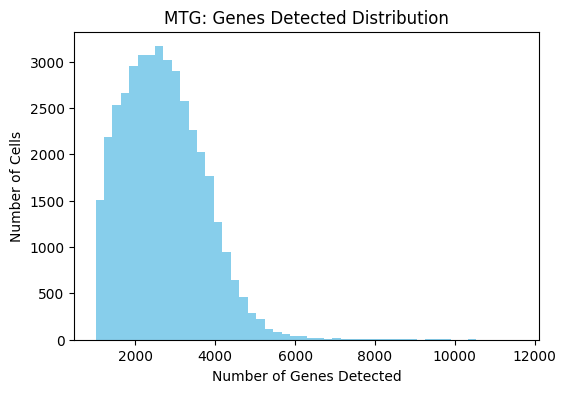

Cells with at least 500 genes detected: 40000


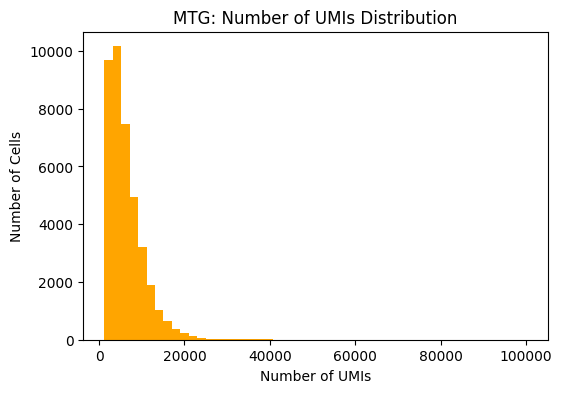

Cells with UMIs between 1000 and 25000: 39820


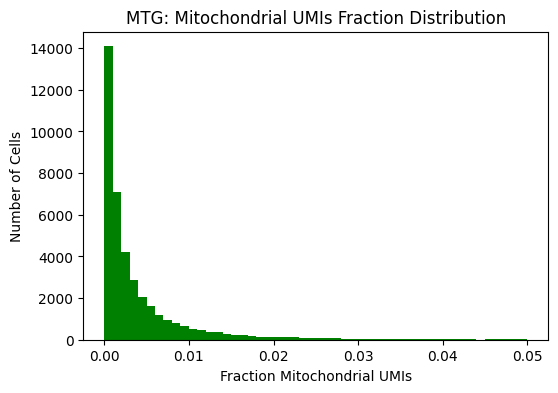

Cells with mitochondrial fraction ≤ 0.05: 39820
Final number of high-quality cells in MTG: 39820

Filtering low-quality cells in DLPFC dataset...


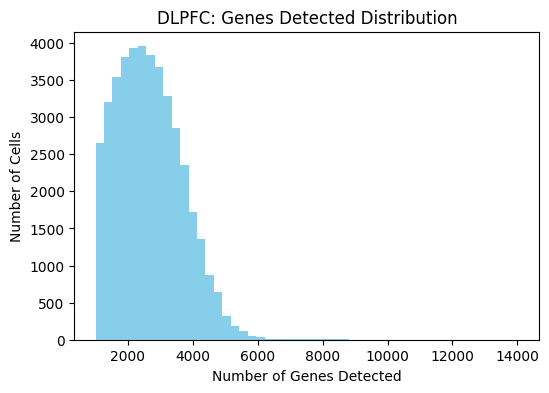

Cells with at least 500 genes detected: 42486


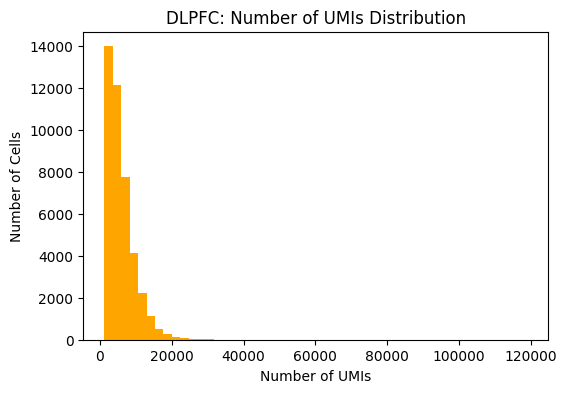

Cells with UMIs between 1000 and 25000: 42404


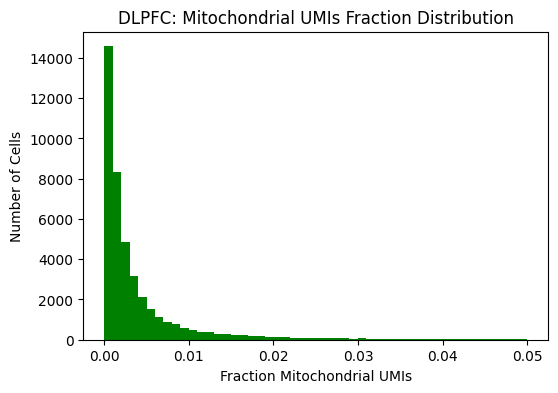

Cells with mitochondrial fraction ≤ 0.05: 42404
Final number of high-quality cells in DLPFC: 42404


In [7]:
# Function to filter out low-quality cells
def filter_low_quality_cells(adata, dataset_name):
    print(f"\nFiltering low-quality cells in {dataset_name} dataset...")

    # Plot histogram of 'Genes detected' to decide on a minimum threshold
    plt.figure(figsize=(6, 4))
    plt.hist(adata.obs['Genes detected'], bins=50, color='skyblue')  # Reduced bins to 50
    plt.xlabel('Number of Genes Detected')
    plt.ylabel('Number of Cells')
    plt.title(f'{dataset_name}: Genes Detected Distribution')
    plt.show()
    plt.close()  # Clear figure to reduce memory usage

    # Set a minimum number of genes detected per cell
    min_genes = 500  # Adjust this threshold based on the histogram
    adata = adata[adata.obs['Genes detected'] >= min_genes, :]
    print(f"Cells with at least {min_genes} genes detected: {adata.n_obs}")

    # Plot histogram of 'Number of UMIs' to decide on thresholds
    plt.figure(figsize=(6, 4))
    plt.hist(adata.obs['Number of UMIs'], bins=50, color='orange')  # Reduced bins to 50
    plt.xlabel('Number of UMIs')
    plt.ylabel('Number of Cells')
    plt.title(f'{dataset_name}: Number of UMIs Distribution')
    plt.show()
    plt.close()  # Clear figure to reduce memory usage

    # Set thresholds for UMIs to exclude doublets or dead cells
    min_umis = 1000   # Adjust based on the histogram
    max_umis = 25000  # Adjust based on the histogram
    adata = adata[(adata.obs['Number of UMIs'] >= min_umis) & (adata.obs['Number of UMIs'] <= max_umis), :]
    print(f"Cells with UMIs between {min_umis} and {max_umis}: {adata.n_obs}")

    # Plot histogram of 'Fraction mitochondrial UMIs' to decide on a maximum threshold
    plt.figure(figsize=(6, 4))
    plt.hist(adata.obs['Fraction mitochrondrial UMIs'], bins=50, color='green')  # Reduced bins to 50
    plt.xlabel('Fraction Mitochondrial UMIs')
    plt.ylabel('Number of Cells')
    plt.title(f'{dataset_name}: Mitochondrial UMIs Fraction Distribution')
    plt.show()
    plt.close()  # Clear figure to reduce memory usage

    # Set a maximum acceptable mitochondrial fraction
    max_mito = 0.05  # Typically between 5% and 10%
    adata = adata[adata.obs['Fraction mitochrondrial UMIs'] <= max_mito, :]
    print(f"Cells with mitochondrial fraction ≤ {max_mito}: {adata.n_obs}")

    print(f"Final number of high-quality cells in {dataset_name}: {adata.n_obs}")
    return adata

# Apply the filtering function on the datasets
try:
    adata_mtg_filtered = filter_low_quality_cells(adata_mtg, 'MTG')
    adata_dlpfc_filtered = filter_low_quality_cells(adata_dlpfc, 'DLPFC')
except MemoryError:
    print("The session ran out of memory. Please try further reducing the dataset size or consider sampling.")



*   Normalize Data:
*   Use methods like log-normalization to make gene expression levels comparable across cells.
*   Implement scaling to adjust for differences in sequencing depth.





## b. Batch Correction:

Identify Batches:


*   Use metadata like Specimen ID or donor_id to identify different batches or donors.




Processing MTG dataset...

MTG Dataset Batch Information:
Batch Information (using 'Specimen ID'): 
 Specimen ID
M2TX_210329_202_F01      582
M1TX_210816_161_F01      491
M1TX_210816_161_E01      481
M2TX_210426_208_A01      463
M2TX_210624_205_D01      461
                        ... 
M2TX_210316_204_E01       12
M1TX_190916_106_B01        5
M2XM_210924_211-R_A01      3
M1TX_190822_101_D01        1
M1TX_191216_107_D01        1
Name: count, Length: 227, dtype: int64


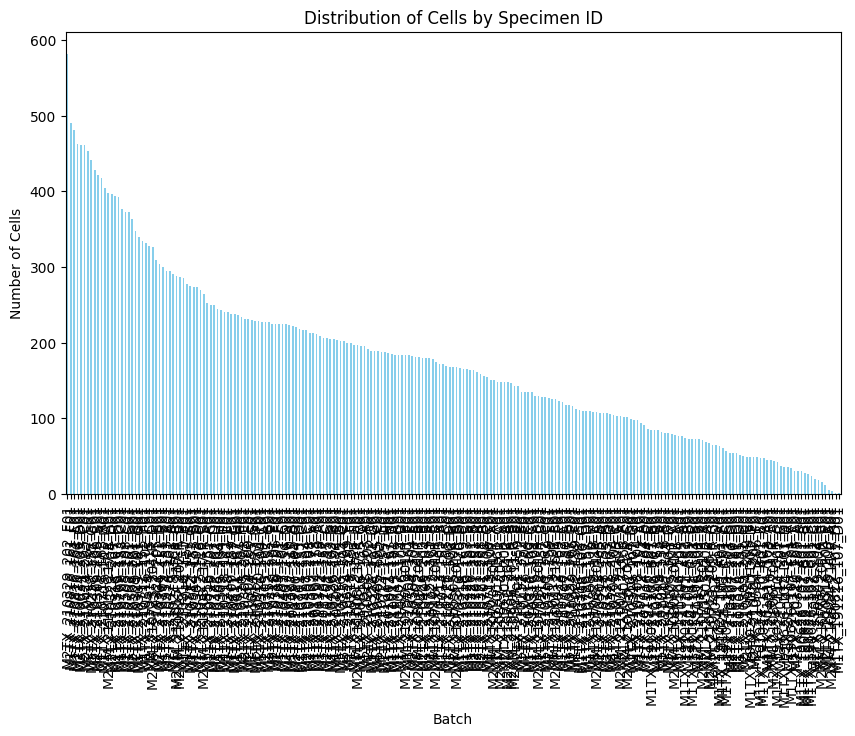

In [8]:
# Function to identify batch information
def identify_batch_info(adata, batch_key='Specimen ID', plot=True):
    # Verify batch key exists
    if batch_key not in adata.obs.columns:
        raise ValueError(f"Batch key '{batch_key}' not found in metadata")

    # Get batch information
    batch_info = adata.obs[batch_key].value_counts()
    print(f"Batch Information (using '{batch_key}'): \n", batch_info)

    # Optionally plot batch distribution
    if plot:
        plt.figure(figsize=(10, 6))
        batch_info.plot(kind='bar', color='skyblue')
        plt.xlabel('Batch')
        plt.ylabel('Number of Cells')
        plt.title(f'Distribution of Cells by {batch_key}')
        plt.show()

    return batch_info

# Call the function with corrected batch key
try:
    print("Processing MTG dataset...")
    print("\nMTG Dataset Batch Information:")
    mtg_batches = identify_batch_info(adata_mtg, batch_key='Specimen ID')
except ValueError as e:
    print(e)


In [9]:
adata_mtg.obs['stage'] = adata_mtg.obs['Braak stage'].map({
    'Braak 0': 'early', 'Braak II': 'early', 'Braak III': 'early',
    'Braak IV': 'advanced', 'Braak V': 'advanced', 'Braak VI': 'advanced'
})
adata_dlpfc.obs['stage'] = adata_dlpfc.obs['Braak stage'].map({
    'Braak 0': 'early', 'Braak II': 'early', 'Braak III': 'early',
    'Braak IV': 'advanced', 'Braak V': 'advanced', 'Braak VI': 'advanced'
})


In [10]:
mtg_apoe4 = adata_mtg[adata_mtg.obs['APOE4 status'] == 'Y']
mtg_non_apoe4 = adata_mtg[adata_mtg.obs['APOE4 status'] == 'N']

dlpfc_apoe4 = adata_dlpfc[adata_dlpfc.obs['APOE4 status'] == 'Y']
dlpfc_non_apoe4 = adata_dlpfc[adata_dlpfc.obs['APOE4 status'] == 'N']


# 2. Data Analysis

## Step 1.1: Examine Dataset Composition
- A summary dictionary of dataset overview information.
- Count distributions for Braak stage, APOE4 status, and Age at death.

In [ ]:
# Basic overview of the dataset
adata_mtg_overview = {
    "Number of Cells": adata_mtg.n_obs,
    "Number of Genes": adata_mtg.n_vars,
    "Available Observations Metadata": list(adata_mtg.obs.columns),
    "Available Features Metadata": list(adata_mtg.var.columns)
}

# Distribution of 'Braak stage' in the dataset
braak_stage_counts = adata_mtg.obs['Braak stage'].value_counts()

# Distribution of 'APOE4 status' in the dataset
apoe4_status_counts = adata_mtg.obs['APOE4 status'].value_counts()

# Visualize 'Braak stage' distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=adata_mtg.obs, x='Braak stage', order=sorted(adata_mtg.obs['Braak stage'].unique()))
plt.title('Distribution of Braak Stages')
plt.xlabel('Braak Stage')
plt.ylabel('Number of Cells')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Visualize 'APOE4 status' distribution
plt.figure(figsize=(8, 5))
sns.countplot(data=adata_mtg.obs, x='APOE4 status', order=sorted(adata_mtg.obs['APOE4 status'].unique()))
plt.title('Distribution of APOE4 Status')
plt.xlabel('APOE4 Status')
plt.ylabel('Number of Cells')
plt.tight_layout()
plt.show()

# Summarize 'Age at death' distribution
age_distribution = adata_mtg.obs['Age at death'].value_counts()

# Visualize 'Age at death' distribution
plt.figure(figsize=(8, 5))
sns.countplot(data=adata_mtg.obs, x='Age at death', order=sorted(adata_mtg.obs['Age at death'].unique()))
plt.title('Distribution of Age at Death')
plt.xlabel('Age Range')
plt.ylabel('Number of Cells')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Return summary statistics and distributions
adata_mtg_overview, braak_stage_counts, apoe4_status_counts, age_distribution

NameError: name 'sns' is not defined

<Figure size 1000x600 with 0 Axes>

## Step 1.2 Basic Demographics of ADNC Score

**General Trends:**

ADNC Scores and **Age**: Higher ADNC scores are correlated with older development stages (ages), which aligns with Alzheimer’s being an age-related disorder.

ADNC Scores and **Gender**: Gender distribution varies, with females more prevalent in higher ADNC scores, possibly reflecting population-level gender differences in Alzheimer's prevalence.

ADNC Scores and **APOE4**: Higher ADNC scores contains higher percentage of APOE4 carriers than lower scores, suggesting APOE4's strong association with higher ADNC stages.

<ipython-input-56-651a5d49ad6f>:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


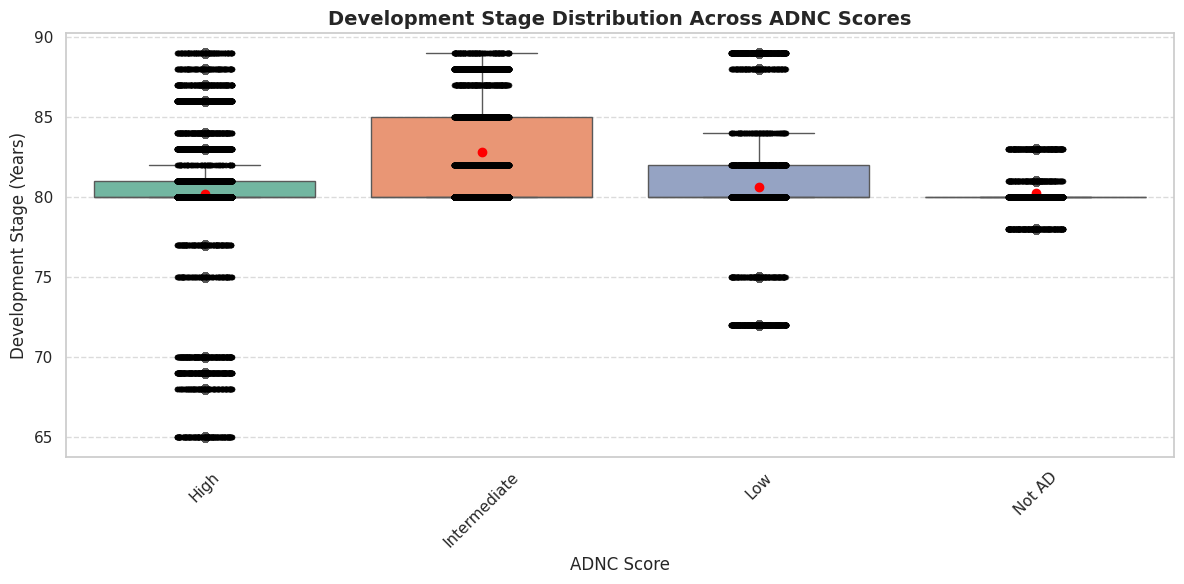

<ipython-input-56-651a5d49ad6f>:72: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  gender_counts = mtg_obs.groupby(['ADNC', 'sex']).size().unstack(fill_value=0)


<Figure size 800x400 with 0 Axes>

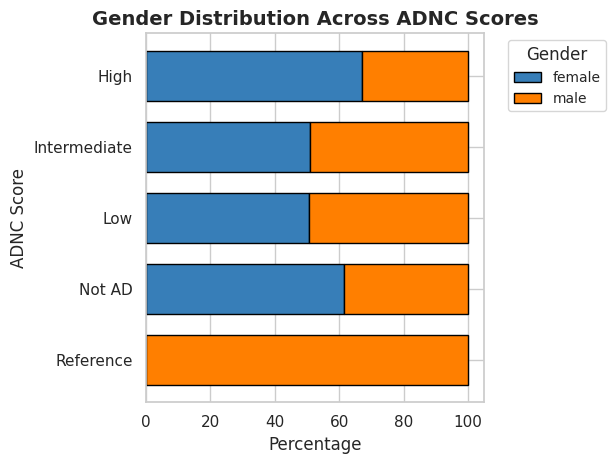

<ipython-input-56-651a5d49ad6f>:85: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  apoe_counts = mtg_obs.groupby(['ADNC', 'APOE4 status']).size().unstack(fill_value=0)


<Figure size 800x400 with 0 Axes>

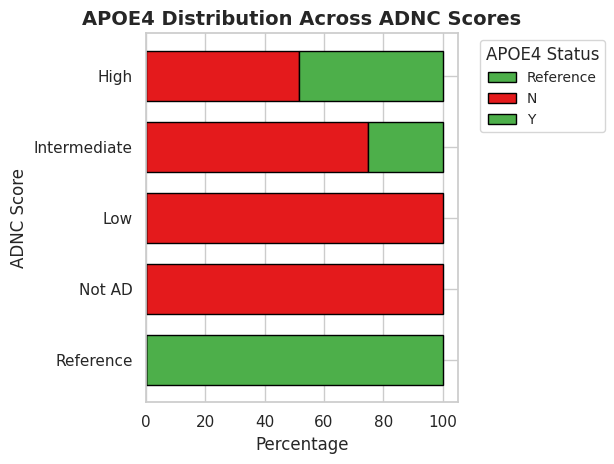

In [ ]:
# Assuming `mtg_obs` is the DataFrame that contains the required data

# Set consistent style for the visualization
sns.set(style="whitegrid", palette="muted")

# Plot 1: Age (Development Stage) Distribution Across ADNC Scores

# Create a mapping of development stage strings to numeric values
development_stage_mapping = {
    '29-year-old stage': 29,
    '43-year-old stage': 43,
    '50-year-old stage': 50,
    '60-year-old stage': 60,
    '65-year-old stage': 65,
    '68-year-old stage': 68,
    '69-year-old stage': 69,
    '70-year-old stage': 70,
    '72-year-old stage': 72,
    '75-year-old stage': 75,
    '77-year-old stage': 77,
    '78-year-old stage': 78,
    '80 year-old and over stage': 80,
    '81-year-old stage': 81,
    '82-year-old stage': 82,
    '83-year-old stage': 83,
    '84-year-old stage': 84,
    '85-year-old stage': 85,
    '86-year-old stage': 86,
    '87-year-old stage': 87,
    '88-year-old stage': 88,
    '89-year-old stage': 89,
    'adult stage': 30  # Approximation for 'adult stage'
}

# Map the development stage strings to numbers
mtg_obs['Development Stage Numeric'] = mtg_obs['development_stage'].map(development_stage_mapping)

# Plot with numeric values
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=mtg_obs,
    x='ADNC',
    y='Development Stage Numeric',
    order=['High', 'Intermediate', 'Low', 'Not AD'],
    palette='Set2',
    showmeans=True,
    meanprops={"marker": "o", "markerfacecolor": "red", "markeredgecolor": "red"}
)
sns.stripplot(
    data=mtg_obs,
    x='ADNC',
    y='Development Stage Numeric',
    jitter=True,
    size=4,
    alpha=0.6,
    color='black',
    order=['High', 'Intermediate', 'Low', 'Not AD']
)
plt.title("Development Stage Distribution Across ADNC Scores", fontsize=14, fontweight='bold')
plt.xlabel("ADNC Score", fontsize=12)
plt.ylabel("Development Stage (Years)", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Plot 2: Gender Distribution Across ADNC Scores
gender_counts = mtg_obs.groupby(['ADNC', 'sex']).size().unstack(fill_value=0)
gender_percentages = gender_counts.div(gender_counts.sum(axis=1), axis=0) * 100

plt.figure(figsize=(8, 4))
gender_percentages.plot(kind='barh', stacked=True, color=['#377eb8', '#ff7f00'], edgecolor='black', width=0.7)
plt.title("Gender Distribution Across ADNC Scores", fontsize=14, fontweight='bold')
plt.xlabel("Percentage", fontsize=12)
plt.ylabel("ADNC Score", fontsize=12)
plt.legend(title="Gender", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.tight_layout()
plt.show()

# Plot 3: APOE4 Distribution Across ADNC Scores
apoe_counts = mtg_obs.groupby(['ADNC', 'APOE4 status']).size().unstack(fill_value=0)
apoe_percentages = apoe_counts.div(apoe_counts.sum(axis=1), axis=0) * 100

plt.figure(figsize=(8, 4))
apoe_percentages.plot(kind='barh', stacked=True, color=['#4daf4a', '#e41a1c'], edgecolor='black', width=0.7)
plt.title("APOE4 Distribution Across ADNC Scores", fontsize=14, fontweight='bold')
plt.xlabel("Percentage", fontsize=12)
plt.ylabel("ADNC Score", fontsize=12)
plt.legend(title="APOE4 Status", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.tight_layout()
plt.show()


## Step 1.3 AD Neuropathological Stages VS. ADNC Scores

**Braak Staging**: Higher ADNC severity correlates with advanced Braak stages, indicating increased neurofibrillary tangle accumulation. "High" ADNC has significant representation in Braak V and VI stages, while "Not AD" and "Low" ADNC are primarily in early stages (Braak II, III).

**Thal Phasing:** Similar trends are observed for amyloid-beta deposition. Higher ADNC severity aligns with advanced Thal phases (Thal 4 and 5). Lower ADNC groups exhibit early Thal phases, indicating less amyloid-beta burden.

**CERAD Score:** The "High" ADNC group predominantly has "Frequent" neuritic plaques, indicating severe pathology. Intermediate ADNC groups show a mixture of "Moderate" and "Sparse" scores, while "Not AD" shows mostly absent plaques.


**Dementia**: The prevalence of dementia increases with ADNC severity, indicating a direct relationship between Alzheimer's pathology and cognitive decline.


<ipython-input-48-a36d084ad1e1>:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  braak_staging = mtg_obs.groupby(['ADNC', 'Braak stage']).size().unstack(fill_value=0)


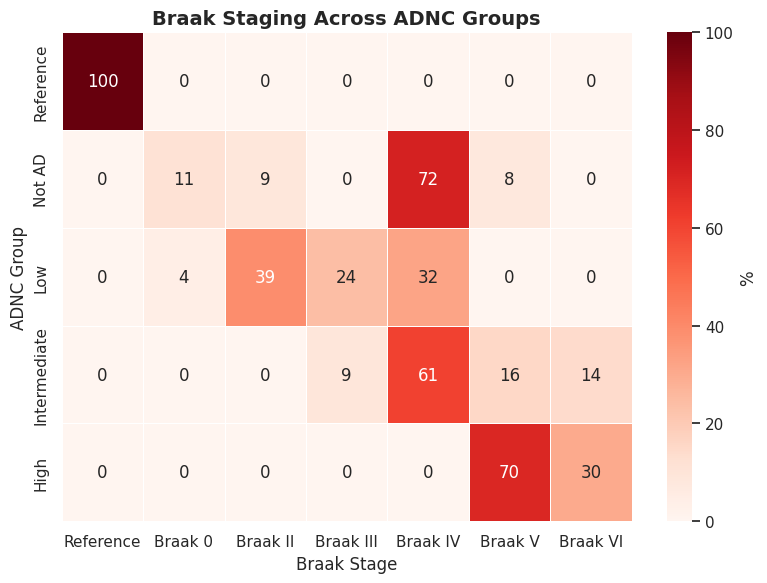

<ipython-input-48-a36d084ad1e1>:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  thal_phasing = mtg_obs.groupby(['ADNC', 'Thal phase']).size().unstack(fill_value=0)


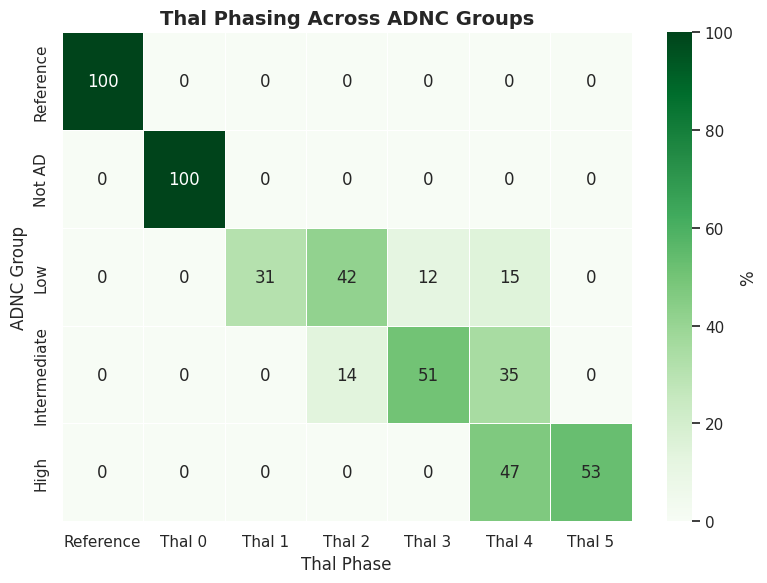

<ipython-input-48-a36d084ad1e1>:33: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cerad_score = mtg_obs.groupby(['ADNC', 'CERAD score']).size().unstack(fill_value=0)


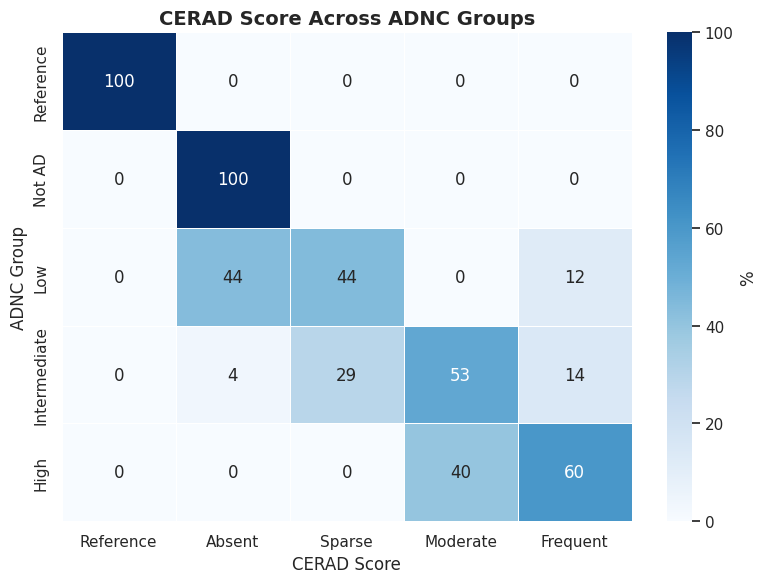

<ipython-input-48-a36d084ad1e1>:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dementia_counts = mtg_obs.groupby(['ADNC', 'Cognitive status']).size().unstack(fill_value=0)


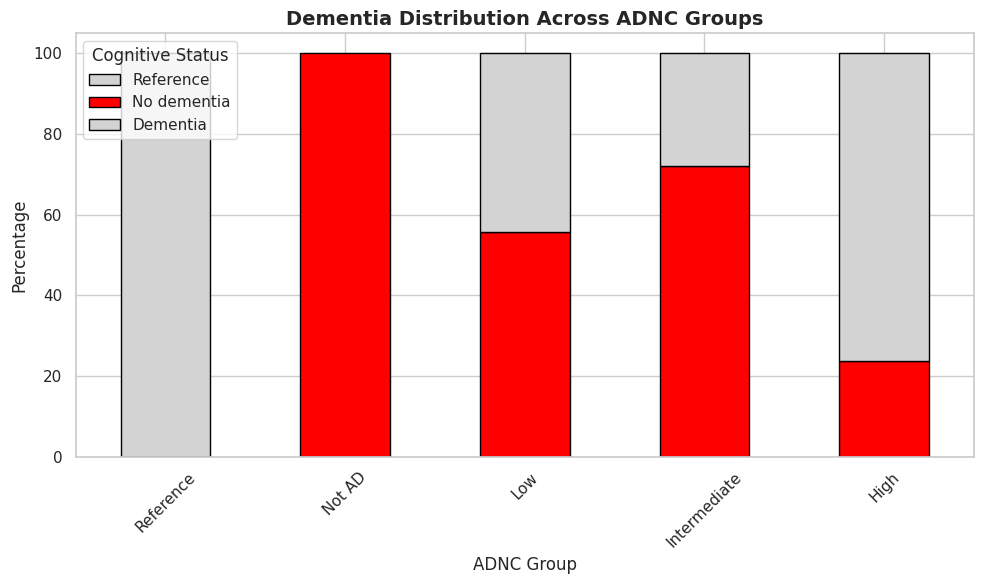

In [ ]:
# Assuming `mtg_obs` is the DataFrame from the provided data

# 1. Heatmap for Braak Staging
braak_staging = mtg_obs.groupby(['ADNC', 'Braak stage']).size().unstack(fill_value=0)
braak_percentage = braak_staging.div(braak_staging.sum(axis=1), axis=0) * 100

plt.figure(figsize=(8, 6))
sns.heatmap(braak_percentage, annot=True, fmt=".0f", cmap="Reds", cbar_kws={'label': '%'}, linewidths=0.5)
plt.title("Braak Staging Across ADNC Groups", fontsize=14, fontweight='bold')
plt.xlabel("Braak Stage")
plt.ylabel("ADNC Group")
plt.tight_layout()
plt.show()

# 2. Heatmap for Thal Phasing
thal_phasing = mtg_obs.groupby(['ADNC', 'Thal phase']).size().unstack(fill_value=0)
thal_percentage = thal_phasing.div(thal_phasing.sum(axis=1), axis=0) * 100

plt.figure(figsize=(8, 6))
sns.heatmap(thal_percentage, annot=True, fmt=".0f", cmap="Greens", cbar_kws={'label': '%'}, linewidths=0.5)
plt.title("Thal Phasing Across ADNC Groups", fontsize=14, fontweight='bold')
plt.xlabel("Thal Phase")
plt.ylabel("ADNC Group")
plt.tight_layout()
plt.show()

# 3. Heatmap for CERAD Score
cerad_score = mtg_obs.groupby(['ADNC', 'CERAD score']).size().unstack(fill_value=0)
cerad_percentage = cerad_score.div(cerad_score.sum(axis=1), axis=0) * 100

plt.figure(figsize=(8, 6))
sns.heatmap(cerad_percentage, annot=True, fmt=".0f", cmap="Blues", cbar_kws={'label': '%'}, linewidths=0.5)
plt.title("CERAD Score Across ADNC Groups", fontsize=14, fontweight='bold')
plt.xlabel("CERAD Score")
plt.ylabel("ADNC Group")
plt.tight_layout()
plt.show()

# 4. Stacked Bar Plot for Dementia
dementia_counts = mtg_obs.groupby(['ADNC', 'Cognitive status']).size().unstack(fill_value=0)
dementia_percentage = dementia_counts.div(dementia_counts.sum(axis=1), axis=0) * 100

dementia_percentage.plot(
    kind='bar',
    stacked=True,
    figsize=(10, 6),
    color=['lightgrey', 'red'],
    edgecolor='black'
)
plt.title("Dementia Distribution Across ADNC Groups", fontsize=14, fontweight='bold')
plt.xlabel("ADNC Group")
plt.ylabel("Percentage")
plt.xticks(rotation=45)
plt.legend(title="Cognitive Status", loc='upper left')
plt.tight_layout()
plt.show()

## Step 2: Dataset Filtering and Preparation
We focus on the MTG dataset (adata_mtg) and isolate relevant observations and features:

Groups: Early AD and Late AD based on Braak stages.

Key genes: Inflammatory pathway genes, genes linked to amyloid-beta clearance, and APOE4 status.

In [99]:
# Map Braak stages to Early and Late AD
braak_to_ad_stage = {
    'Braak 0': 'Early AD',
    'Braak II': 'Early AD',
    'Braak III': 'Early AD',
    'Braak IV': 'Late AD',
    'Braak V': 'Late AD',
    'Braak VI': 'Late AD'
}
adata_mtg.obs['AD Stage'] = adata_mtg.obs['Braak stage'].map(braak_to_ad_stage)

# Filter for valid AD stages
adata_filtered = adata_mtg[adata_mtg.obs['AD Stage'].notnull()]


<ipython-input-99-e13152ff9629>:10: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_mtg.obs['AD Stage'] = adata_mtg.obs['Braak stage'].map(braak_to_ad_stage)


## Step 3: Differential Expression Analysis
Compare Early AD vs. Late AD to identify differentially expressed genes.



## 3.1 Differential Gene Expression
- Stages are categorized in a intergrated way.

1. Compare early vs. advanced AD stages.
2. Separate analysis for APOE4 carriers and non-carriers.
python


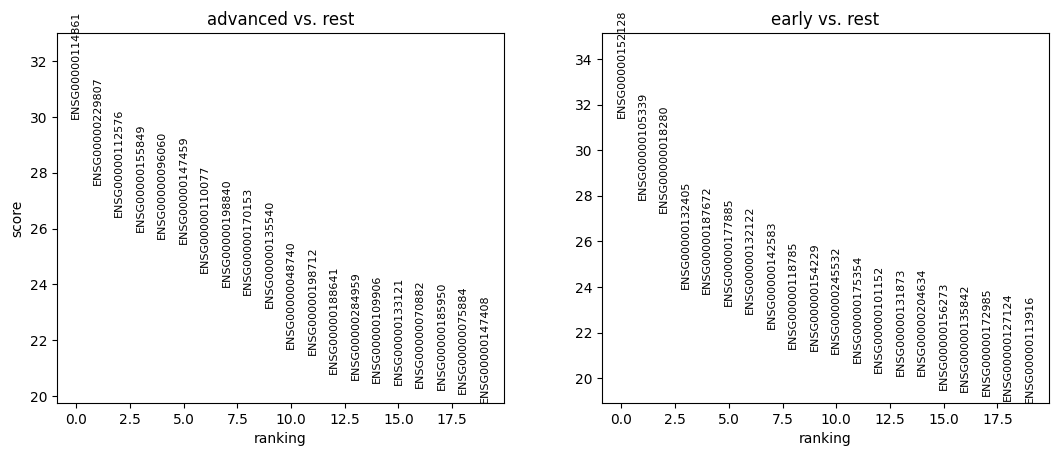

/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1146: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


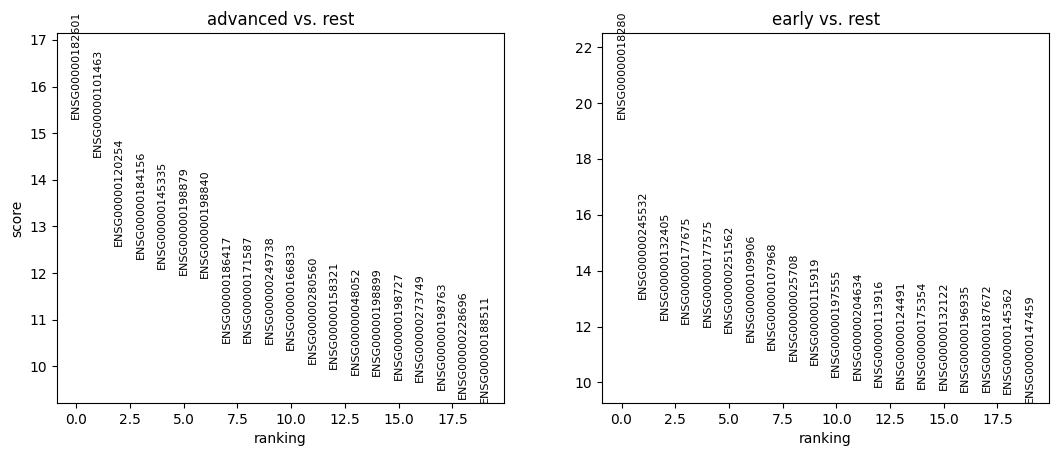

/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1146: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


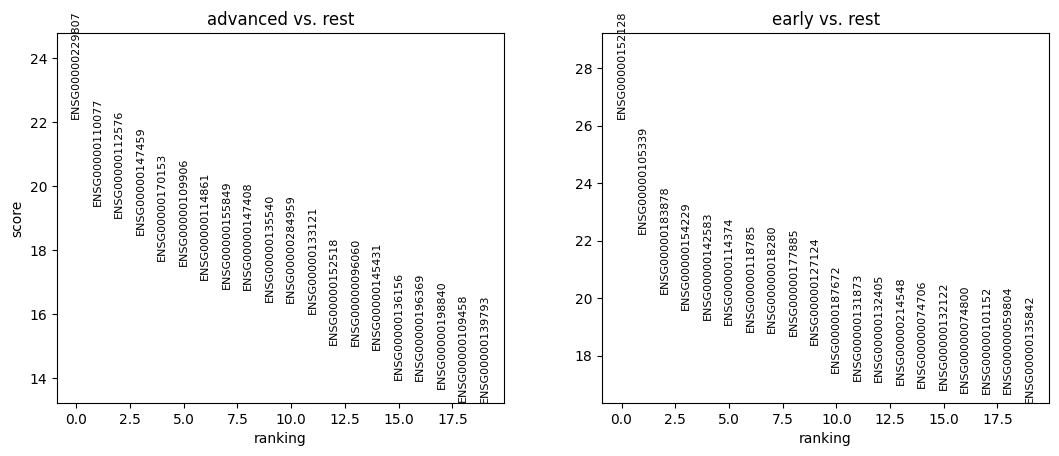

In [13]:
# Early vs. Advanced
sc.tl.rank_genes_groups(adata_mtg, 'stage', method='wilcoxon')
sc.pl.rank_genes_groups(adata_mtg, n_genes=10, sharey=False)

# APOE4 carriers
sc.tl.rank_genes_groups(mtg_apoe4, 'stage', method='wilcoxon')
sc.pl.rank_genes_groups(mtg_apoe4, n_genes=10, sharey=False)

# Non-carriers
sc.tl.rank_genes_groups(mtg_non_apoe4, 'stage', method='wilcoxon')
sc.pl.rank_genes_groups(mtg_non_apoe4, n_genes=10, sharey=False)


In [16]:
# Function to extract top-ranked genes for a specific group
def extract_top_genes(adata, group, n_genes=10):
    ranked_genes = adata.uns['rank_genes_groups']
    genes = pd.DataFrame(ranked_genes['names']).head(n_genes)
    return genes[group]

# Extract and print top-ranked genes for each analysis
print("Early vs. Advanced (Top Genes for Early):")
early_genes = extract_top_genes(adata_mtg, 'early')
print(early_genes)

print("\nEarly vs. Advanced (Top Genes for Advanced):")
advanced_genes = extract_top_genes(adata_mtg, 'advanced')
print(advanced_genes)

print("\nAPOE4 Carriers (Top Genes for Early):")
apoe4_early_genes = extract_top_genes(mtg_apoe4, 'early')
print(apoe4_early_genes)

print("\nAPOE4 Carriers (Top Genes for Advanced):")
apoe4_advanced_genes = extract_top_genes(mtg_apoe4, 'advanced')
print(apoe4_advanced_genes)

print("\nNon-carriers (Top Genes for Early):")
non_apoe4_early_genes = extract_top_genes(mtg_non_apoe4, 'early')
print(non_apoe4_early_genes)

print("\nNon-carriers (Top Genes for Advanced):")
non_apoe4_advanced_genes = extract_top_genes(mtg_non_apoe4, 'advanced')
print(non_apoe4_advanced_genes)


Early vs. Advanced (Top Genes for Early):
0    ENSG00000152128
1    ENSG00000105339
2    ENSG00000018280
3    ENSG00000132405
4    ENSG00000187672
5    ENSG00000177885
6    ENSG00000132122
7    ENSG00000142583
8    ENSG00000118785
9    ENSG00000154229
Name: early, dtype: object

Early vs. Advanced (Top Genes for Advanced):
0    ENSG00000114861
1    ENSG00000229807
2    ENSG00000112576
3    ENSG00000155849
4    ENSG00000096060
5    ENSG00000147459
6    ENSG00000110077
7    ENSG00000198840
8    ENSG00000170153
9    ENSG00000135540
Name: advanced, dtype: object

APOE4 Carriers (Top Genes for Early):
0    ENSG00000018280
1    ENSG00000245532
2    ENSG00000132405
3    ENSG00000177675
4    ENSG00000177575
5    ENSG00000251562
6    ENSG00000109906
7    ENSG00000107968
8    ENSG00000025708
9    ENSG00000115919
Name: early, dtype: object

APOE4 Carriers (Top Genes for Advanced):
0    ENSG00000182601
1    ENSG00000101463
2    ENSG00000120254
3    ENSG00000184156
4    ENSG00000145335
5    ENSG000

In [11]:
!pip install mygene

In [17]:
import mygene

# Initialize the MyGeneInfo client
mg = mygene.MyGeneInfo()

# List of ENSG IDs for each group
gene_groups = {
    "Early vs. Advanced (Early)": [
        "ENSG00000152128", "ENSG00000105339", "ENSG00000018280", "ENSG00000132405",
        "ENSG00000187672", "ENSG00000177885", "ENSG00000132122", "ENSG00000142583",
        "ENSG00000118785", "ENSG00000154229"
    ],
    "Early vs. Advanced (Advanced)": [
        "ENSG00000114861", "ENSG00000229807", "ENSG00000112576", "ENSG00000155849",
        "ENSG00000096060", "ENSG00000147459", "ENSG00000110077", "ENSG00000198840",
        "ENSG00000170153", "ENSG00000135540"
    ],
    "APOE4 Carriers (Early)": [
        "ENSG00000018280", "ENSG00000245532", "ENSG00000132405", "ENSG00000177675",
        "ENSG00000177575", "ENSG00000251562", "ENSG00000109906", "ENSG00000107968",
        "ENSG00000025708", "ENSG00000115919"
    ],
    "APOE4 Carriers (Advanced)": [
        "ENSG00000182601", "ENSG00000101463", "ENSG00000120254", "ENSG00000184156",
        "ENSG00000145335", "ENSG00000198879", "ENSG00000198840", "ENSG00000186417",
        "ENSG00000171587", "ENSG00000249738"
    ],
    "Non-carriers (Early)": [
        "ENSG00000152128", "ENSG00000105339", "ENSG00000183878", "ENSG00000154229",
        "ENSG00000142583", "ENSG00000114374", "ENSG00000118785", "ENSG00000018280",
        "ENSG00000177885", "ENSG00000127124"
    ],
    "Non-carriers (Advanced)": [
        "ENSG00000229807", "ENSG00000110077", "ENSG00000112576", "ENSG00000147459",
        "ENSG00000170153", "ENSG00000109906", "ENSG00000114861", "ENSG00000155849",
        "ENSG00000147408", "ENSG00000135540"
    ]
}

# Query gene names and symbols
gene_mapping_results = {}

for group, genes in gene_groups.items():
    mapped_genes = mg.querymany(genes, scopes='ensembl.gene', fields='symbol,name', species='human')
    gene_mapping_results[group] = [
        {
            "ENSG ID": gene.get('query'),
            "Symbol": gene.get('symbol', 'N/A'),
            "Name": gene.get('name', 'N/A')
        }
        for gene in mapped_genes
    ]

gene_mapping_results


INFO:biothings.client:querying 1-10...
INFO:biothings.client:done.
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-10...
INFO:biothings.client:done.
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-10...
INFO:biothings.client:done.
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-10...
INFO:biothings.client:done.
INFO:biothings.client:Finished.
INFO:biothings.client:Pass "returnall=True" to return complete lists of duplicate or missing query terms.
INFO:biothings.client:querying 1-10...
INFO:biothings.client:done.
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-10...
INFO:biothings.client:done.
INFO:biothings.client:Finished.


{'Early vs. Advanced (Early)': [{'ENSG ID': 'ENSG00000152128',
   'Symbol': 'TMEM163',
   'Name': 'transmembrane protein 163'},
  {'ENSG ID': 'ENSG00000105339',
   'Symbol': 'DENND3',
   'Name': 'DENN domain containing 3'},
  {'ENSG ID': 'ENSG00000018280',
   'Symbol': 'SLC11A1',
   'Name': 'solute carrier family 11 member 1'},
  {'ENSG ID': 'ENSG00000132405',
   'Symbol': 'TBC1D14',
   'Name': 'TBC1 domain family member 14'},
  {'ENSG ID': 'ENSG00000187672',
   'Symbol': 'ERC2',
   'Name': 'ELKS/RAB6-interacting/CAST family member 2'},
  {'ENSG ID': 'ENSG00000177885',
   'Symbol': 'GRB2',
   'Name': 'growth factor receptor bound protein 2'},
  {'ENSG ID': 'ENSG00000132122',
   'Symbol': 'SPATA6',
   'Name': 'spermatogenesis associated 6'},
  {'ENSG ID': 'ENSG00000142583',
   'Symbol': 'SLC2A5',
   'Name': 'solute carrier family 2 member 5'},
  {'ENSG ID': 'ENSG00000118785',
   'Symbol': 'SPP1',
   'Name': 'secreted phosphoprotein 1'},
  {'ENSG ID': 'ENSG00000154229',
   'Symbol': 'PRK

### 1. Early vs. Advanced Stages

  **Early Stage Genes:**

1. Ion Transport and Cellular Homeostasis: TMEM163: Literature indicates TMEM163's role in zinc transport, essential for neuronal health and neuroprotection in AD brains [1]. Our findings highlight TMEM163 as a protective gene in early AD stages, suggesting it could be a therapeutic target to support neuronal health by regulating zinc levels.


2. Cellular Signaling and Adaptation: GRB2 (growth factor receptor bound protein 2): GRB2 mediates growth factor signaling, which is critical for cellular survival and repair. In the context of AD, this could be protective by supporting neuronal survival and potentially aiding in repair mechanisms.

3. Autophagy and Stress Response: TBC1D14 (TBC1 domain family member 14): TBC1D14 regulates autophagy, contributing to cellular stress management. Autophagy is an important process for clearing cellular debris and protein aggregates, which could be protective against AD pathology.

5. Synaptic Function and Organization: ERC2 (ELKS/RAB6-interacting/CAST family member 2): ERC2 plays a role in synaptic vesicle trafficking, supporting neuronal communication. Maintaining healthy synaptic function could be protective against AD-related synaptic loss.



**Conclusion**:
1. These genes collectively emphasize neuroprotective mechanisms such as maintaining ionic balance, reducing oxidative stress, and repairing extracellular matrix damage.
2. They support immune homeostasis and adaptive cellular responses to stress, aligning with the hypothesis that early-stage microglial activation prioritizes neuroprotection and repair.




**Advanced Stage Genes:**
1. ELMO1: Part of MAPK pathway; drives inflammatory and neurotoxic microglial activation. Promotes inflammation, exacerbating AD progression.

2. FKBP5: Increases neurotoxic tau oligomer production; upregulated in AD brains. Enhances tau toxicity and age-related neurodegeneration.
3. MS4A6A: Elevated in AD patients; linked to early pathological changes Exacerbates inflammation and neurotoxicity.
4. ND3: Impaired oxidative phosphorylation; hallmark of late-stage AD.
Mechanism: Causes mitochondrial dysfunction, energy deficits, and oxidative stress.


**Conclusion**:
- Neuroinflammatory and Dysregulated States: The presence of FKBP5 highlights chronic stress and immune dysregulation, while DOCK5 reflects dysfunctional attempts by microglia to maintain homeostasis and clear plaques.

- Progression of Neurotoxicity: These genes support the hypothesis that microglia shift toward neurotoxic and dysfunctional states in advanced AD, failing to resolve inflammation and contributing to disease progression.


**Early stage vs. Late stage:** Early-stage genes are aligned with repair and stress responses, while advanced-stage genes reflect sustained microglial activation, mitochondrial dysfunction, and inflammation, which exacerbate neurodegeneration in Alzheimer’s disease.

###   APOE4 Impact on Gene Expression
Early Stage:

APOE4 Carriers:

Genes (SLC11A1, CD163, MAP3K8) show heightened inflammation and immune activity, indicating an accelerated shift from neuroprotection to neuroinflammation.

Non-coding RNAs (NEAT1, MALAT1) and metabolic markers (KYNU, TYMP) reflect stress response and immune regulation.

Non-Carriers:

Genes (TMEM163, PRKCA, SPP1) emphasize balanced neuroprotection, including synaptic repair and anti-inflammatory roles.

Shared marker SLC11A1 supports common neuroprotective functions.

Advanced Stage:
APOE4 Carriers:

Genes (SNCA, MTHFD1L, DSCAM) highlight severe neurodegeneration, synaptic loss, and mitochondrial dysfunction.

Synapse-related genes (HS3ST4, SYNDIG1) indicate advanced synaptic dysregulation.

Non-Carriers:

Genes (FOXP1, MS4A6A, DOCK5) indicate chronic inflammation and structural remodeling, with less severe mitochondrial and synaptic disruption compared to carriers.

**Implications:**
APOE4 carriers exhibit a more aggressive immune response in the early stages (CD163, MAP3K8) and a faster shift toward neurotoxic outcomes in the advanced stages (SNCA, SYNDIG1). Non-carriers progress more gradually, maintaining neuroprotective processes for a longer duration.

### Log Result

/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1146: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


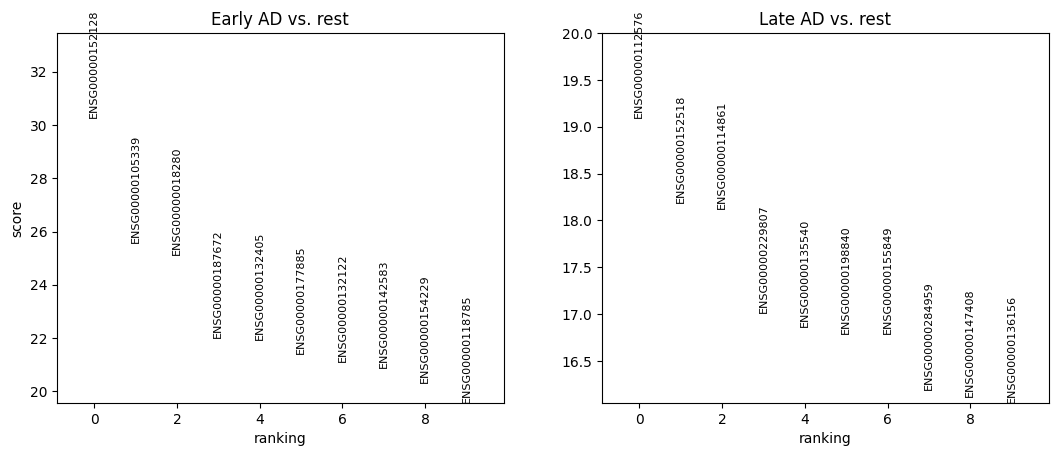

In [ ]:
# Normalize the total counts per cell to 10,000 (default behavior)
sc.pp.normalize_total(adata_filtered, target_sum=1e4)

# Logarithmize the data for variance stabilization
sc.pp.log1p(adata_filtered)

# Perform differential expression analysis
sc.tl.rank_genes_groups(
    adata_filtered,
    groupby='AD Stage',  # Grouping by the column that defines AD stages
    method='wilcoxon'   # Wilcoxon rank-sum test for comparison
)

# Plot the top 10 differentially expressed genes
sc.pl.rank_genes_groups(
    adata_filtered,
    n_genes=10,  # Number of top genes to display
    sharey=False # Allows each subplot to have its own scale
)


## 3.2 Top 10 significant genes "Early AD" vs. "Late AD." using Braak Stage

1. Map Braak Stages to "Early AD" and "Late AD":

  The Braak stages, which represent the progression of Alzheimer's pathology, are categorized into "Early AD" (stages 0, II, III) and "Late AD" (stages IV, V, VI).

  This step helps group data for comparison based on disease progression.

2. Perform Statistical Analysis (t-test):

  A two-sample t-test is performed for each gene to test if its mean expression differs significantly between "Early AD" and "Late AD."



<ipython-input-10-790776502aa3>:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


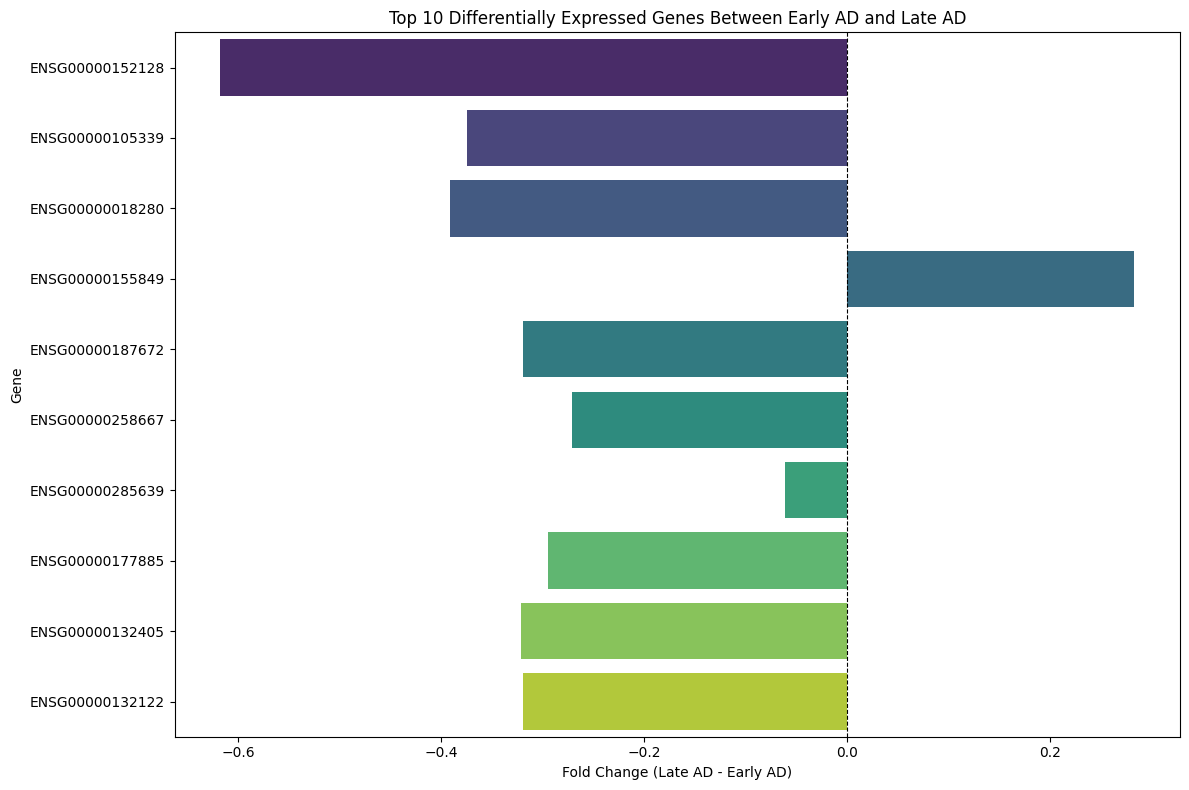

In [10]:
# Recompute the top differentially expressed genes between Early AD and Late AD

import numpy as np
import pandas as pd
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns

# Map Braak stages to Early AD and Late AD
braak_to_ad_stage = {
    'Braak 0': 'Early AD',
    'Braak II': 'Early AD',
    'Braak III': 'Early AD',
    'Braak IV': 'Late AD',
    'Braak V': 'Late AD',
    'Braak VI': 'Late AD'
}

# Assuming `adata_mtg` is the AnnData object and contains the required data
adata_mtg.obs['AD Stage'] = adata_mtg.obs['Braak stage'].map(braak_to_ad_stage)

# Filter the dataset for Early AD and Late AD
valid_obs = adata_mtg.obs['AD Stage'].notnull()
adata_filtered = adata_mtg[valid_obs]

# Get group indices
early_ad_indices = np.where(adata_filtered.obs['AD Stage'] == 'Early AD')[0]
late_ad_indices = np.where(adata_filtered.obs['AD Stage'] == 'Late AD')[0]

# Perform t-tests for all genes at once
X = adata_filtered.X.toarray()
early_ad_expr = X[early_ad_indices, :]
late_ad_expr = X[late_ad_indices, :]

# Compute mean expression and t-test
early_means = np.mean(early_ad_expr, axis=0)
late_means = np.mean(late_ad_expr, axis=0)
t_stats, p_values = ttest_ind(early_ad_expr, late_ad_expr, axis=0, nan_policy='omit')

# Create a results DataFrame
results_df = pd.DataFrame({
    'Gene': adata_filtered.var_names,
    'Early AD Mean': early_means,
    'Late AD Mean': late_means,
    't-statistic': t_stats,
    'p-value': p_values,
    'Fold Change': late_means - early_means
})

# Sort by significance (smallest p-value)
significant_genes = results_df.sort_values('p-value').head(10)

# Plot the top 10 genes as a general bar plot
plt.figure(figsize=(12, 8))

# Plot fold changes for top 10 significant genes
sns.barplot(
    data=significant_genes,
    x='Fold Change',
    y='Gene',
    palette='viridis'
)

# Add titles and labels
plt.title('Top 10 Differentially Expressed Genes Between Early AD and Late AD')
plt.xlabel('Fold Change (Late AD - Early AD)')
plt.ylabel('Gene')
plt.axvline(0, color='black', linestyle='--', linewidth=0.8)  # Highlight zero fold change
plt.tight_layout()
plt.show()



### Insights
1. Microglial Functionality:

- The downregulation of TMEM163, DENND3, CRIP2, ERC2,	TBC1D14 in Late AD may suggest a loss of neuroprotective or homeostatic functions of microglia during disease progression.

- The upregulation of **ELMO1** supports its role in inflammatory or neurotoxic activation, consistent with the shift in microglial behavior.

2. Support for the Hypothesis:

  These findings support the hypothesis that microglial activation transitions from neuroprotective to neurotoxic as Alzheimer's Disease progresses.

3. Further Analysis:

  Investigate the pathways and biological processes these genes are involved in (e.g., inflammation, phagocytosis, or neuronal homeostasis).



## Step 4:  Analyze Gene Expression Across Braak Stages for AD Inflammatory Markers

**Objective:**
Quantify changes in the expression of neuroprotective (e.g., TREM2) and neurotoxic (e.g., IL6) genes across Braak stages.

<Figure size 1200x600 with 0 Axes>

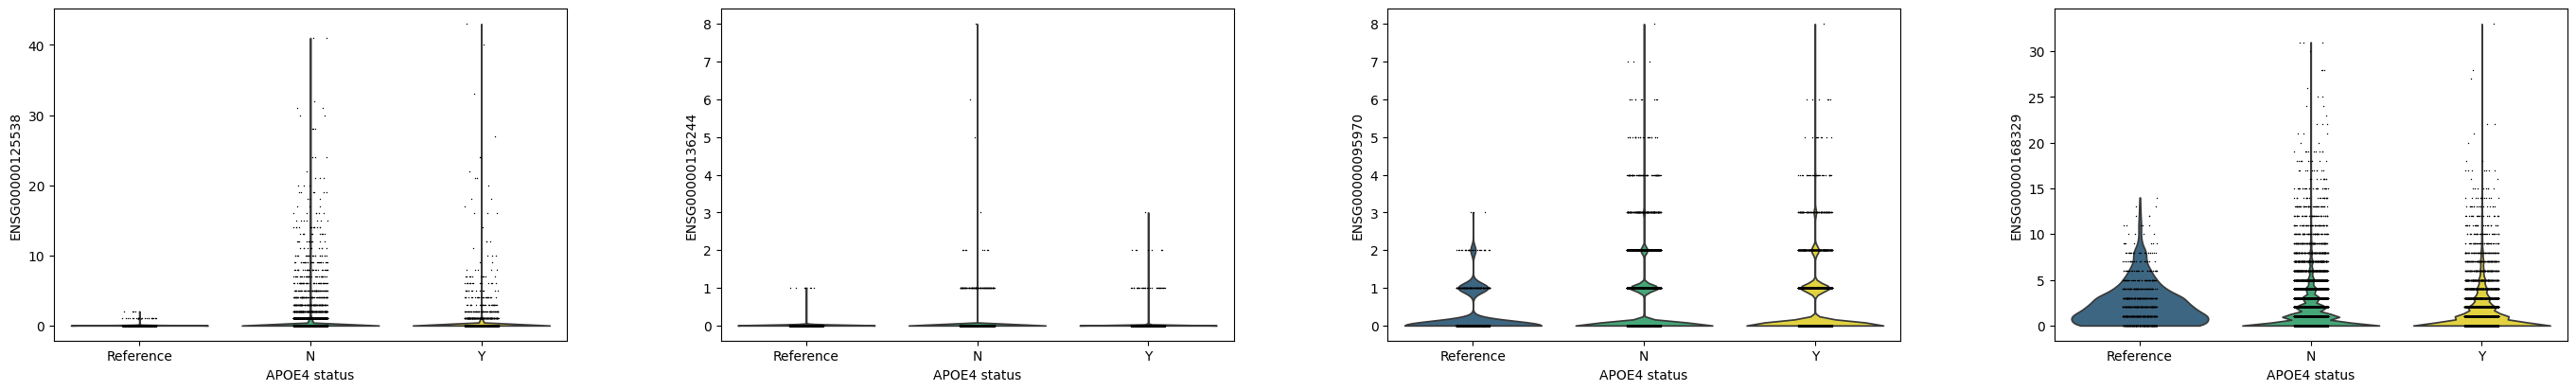

<Figure size 640x480 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

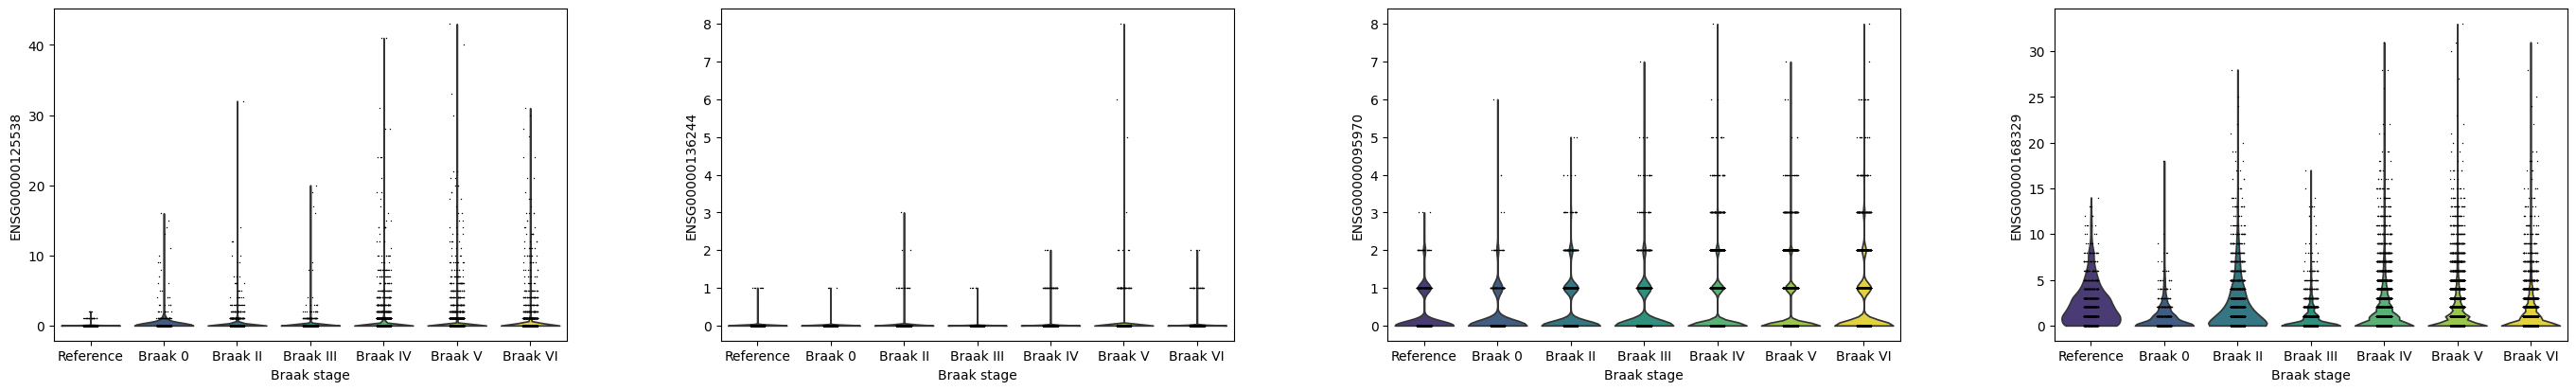

<Figure size 640x480 with 0 Axes>

In [ ]:
# List of genes for inflammatory markers
genes_of_interest = ['ENSG00000125538', 'ENSG00000136244', 'ENSG00000095970', 'ENSG00000168329']  # IL1B, IL6, TREM2, CX3CR1

# Set figure size using matplotlib
plt.figure(figsize=(12, 6))

# Plot the expression of the genes of interest (Violin plot)
sc.pl.violin(adata_mtg, keys=genes_of_interest, groupby='APOE4 status', jitter=True)
plt.suptitle('Gene Expression of Inflammatory Markers in APOE4 Carriers vs Non-Carriers')
plt.show()

# Investigating how genes like IL1B, TNF, TREM2, and CX3CR1 behave differently in APOE4 carriers across Braak stages
plt.figure(figsize=(12, 6))
sc.pl.violin(adata_mtg, keys=genes_of_interest, groupby='Braak stage', hue='APOE4 status', jitter=True)
plt.suptitle('Gene Expression of Inflammatory Markers Across Disease Stages (APOE4 carriers vs Non-carriers)')
plt.show()


### Key findings
1. APOE4 Status Comparison: The differences in expression between APOE4 carriers and non-carriers are minimal.

2.  Braak Stage Comparison (Disease Progression)

IL1B (ENSG00000125538), CX3CR1 (ENSG00000168329) and TREM2 (ENSG00000095970) show increased expression in later Braak stages (IV, V, VI). This indicates that these genes are more active in the advanced stages of AD.

/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_pca.py:317: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca
<ipython-input-84-beabdd620cf9>:7: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(microglia, resolution=0.5)  # Adjust resolution for granularity


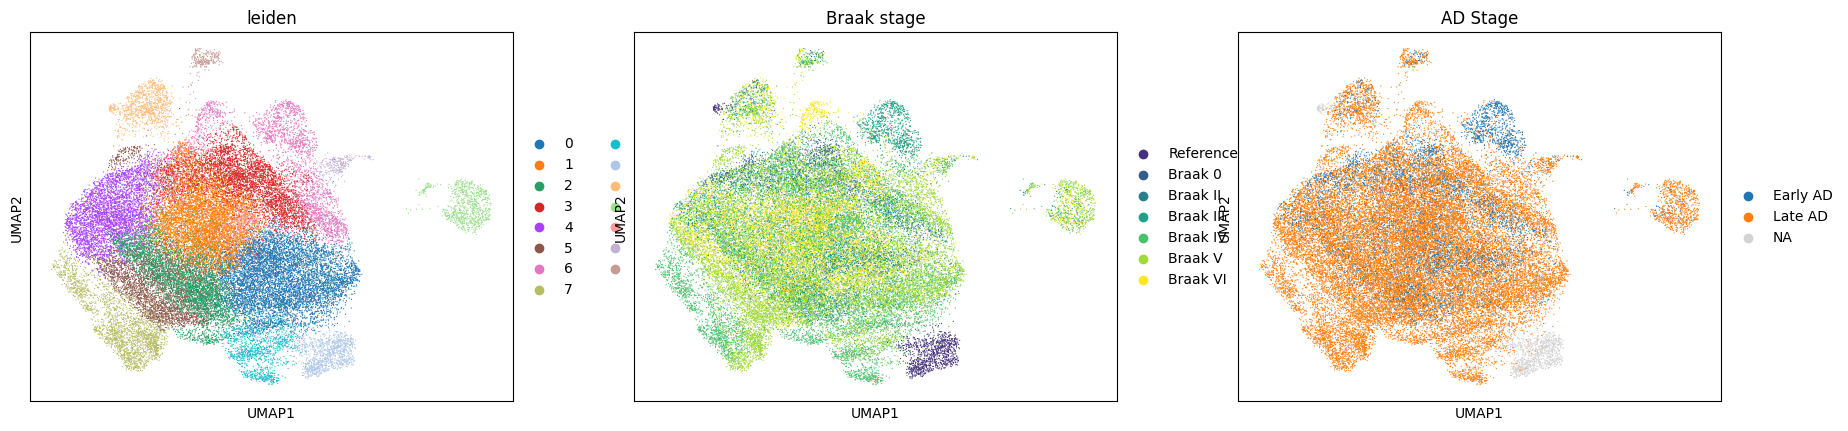

Number of microglial cells: 40000
Number of genes: 36412
  (0, 2)	1.0842869281768799
  (2, 2)	1.8683271408081055
  (3, 3)	1.5740773677825928
  (3, 4)	1.069232702255249


In [ ]:
# Filter microglial cells
microglia = adata_mtg[adata_mtg.obs['cell_type'] == 'microglial cell']

# Perform PCA and clustering
sc.tl.pca(microglia)
sc.pp.neighbors(microglia, n_neighbors=15, n_pcs=20)
sc.tl.leiden(microglia, resolution=0.5)  # Adjust resolution for granularity

# UMAP for visualization
sc.tl.umap(microglia)

# Plot UMAP
sc.pl.umap(microglia, color=['leiden', 'Braak stage', 'AD Stage'])

# Check the number of cells and genes in the filtered data
print("Number of microglial cells:", microglia.n_obs)
print("Number of genes:", microglia.n_vars)

# Verify the expression matrix
print(microglia.X[:5, :5])  # Check the first 5 rows and columns


## Step 5.1: Pathway Enrichment Analysis

In [18]:
import gseapy as gp
import pandas as pd

# Step 1: Define gene lists for early and advanced stages
early_genes = ["TMEM163", "DENND3", "SLC11A1", "TBC1D14", "ERC2", "GRB2", "SPATA6", "SLC2A5", "SPP1", "PRKCA"]
advanced_genes = ["FOXP1", "XIST", "CCND3", "ELMO1", "FKBP5", "DOCK5", "MS4A6A", "ND3", "RNF150", "NHSL1"]

# Step 2: Convert gene lists to DataFrame (required by GSEA)
early_genes_df = pd.DataFrame({"gene": early_genes})
advanced_genes_df = pd.DataFrame({"gene": advanced_genes})

# Step 3: Perform pathway enrichment analysis for KEGG pathways
print("Performing KEGG pathway enrichment analysis for Early Stage genes...")
early_kegg = gp.enrichr(gene_list=early_genes,
                        gene_sets="KEGG_2021_Human",  # Use KEGG pathways for human
                        organism='human',            # Organism name
                        outdir=None)                 # No output directory

print("Performing KEGG pathway enrichment analysis for Advanced Stage genes...")
advanced_kegg = gp.enrichr(gene_list=advanced_genes,
                           gene_sets="KEGG_2021_Human",
                           organism='human',
                           outdir=None)

# Step 4: Perform pathway enrichment analysis for Reactome pathways
print("Performing Reactome pathway enrichment analysis for Early Stage genes...")
early_reactome = gp.enrichr(gene_list=early_genes,
                            gene_sets="Reactome_2022",
                            organism='human',
                            outdir=None)

print("Performing Reactome pathway enrichment analysis for Advanced Stage genes...")
advanced_reactome = gp.enrichr(gene_list=advanced_genes,
                               gene_sets="Reactome_2022",
                               organism='human',
                               outdir=None)

# Step 5: Display top enriched pathways for Early and Advanced stages
print("\nTop KEGG pathways for Early Stage genes:")
print(early_kegg.results[['Term', 'Adjusted P-value', 'Overlap', 'Combined Score']].head(10))

print("\nTop KEGG pathways for Advanced Stage genes:")
print(advanced_kegg.results[['Term', 'Adjusted P-value', 'Overlap', 'Combined Score']].head(10))

print("\nTop Reactome pathways for Early Stage genes:")
print(early_reactome.results[['Term', 'Adjusted P-value', 'Overlap', 'Combined Score']].head(10))

print("\nTop Reactome pathways for Advanced Stage genes:")
print(advanced_reactome.results[['Term', 'Adjusted P-value', 'Overlap', 'Combined Score']].head(10))


Performing KEGG pathway enrichment analysis for Early Stage genes...
Performing KEGG pathway enrichment analysis for Advanced Stage genes...
Performing Reactome pathway enrichment analysis for Early Stage genes...
Performing Reactome pathway enrichment analysis for Advanced Stage genes...

Top KEGG pathways for Early Stage genes:
                              Term  Adjusted P-value Overlap  Combined Score
0                   Focal adhesion          0.010308   3/201      388.987276
1                   GnRH secretion          0.010308    2/64      619.922544
2  Fc epsilon RI signaling pathway          0.010308    2/68      573.093987
3       Non-small cell lung cancer          0.010308    2/72      532.121352
4       PI3K-Akt signaling pathway          0.010308   3/354      177.829494
5                           Glioma          0.010308    2/75      504.623799
6           ErbB signaling pathway          0.010528    2/85      428.657767
7                     Gap junction          0.010528

Performing KEGG pathway enrichment analysis for Early Stage genes...
Performing KEGG pathway enrichment analysis for Advanced Stage genes...


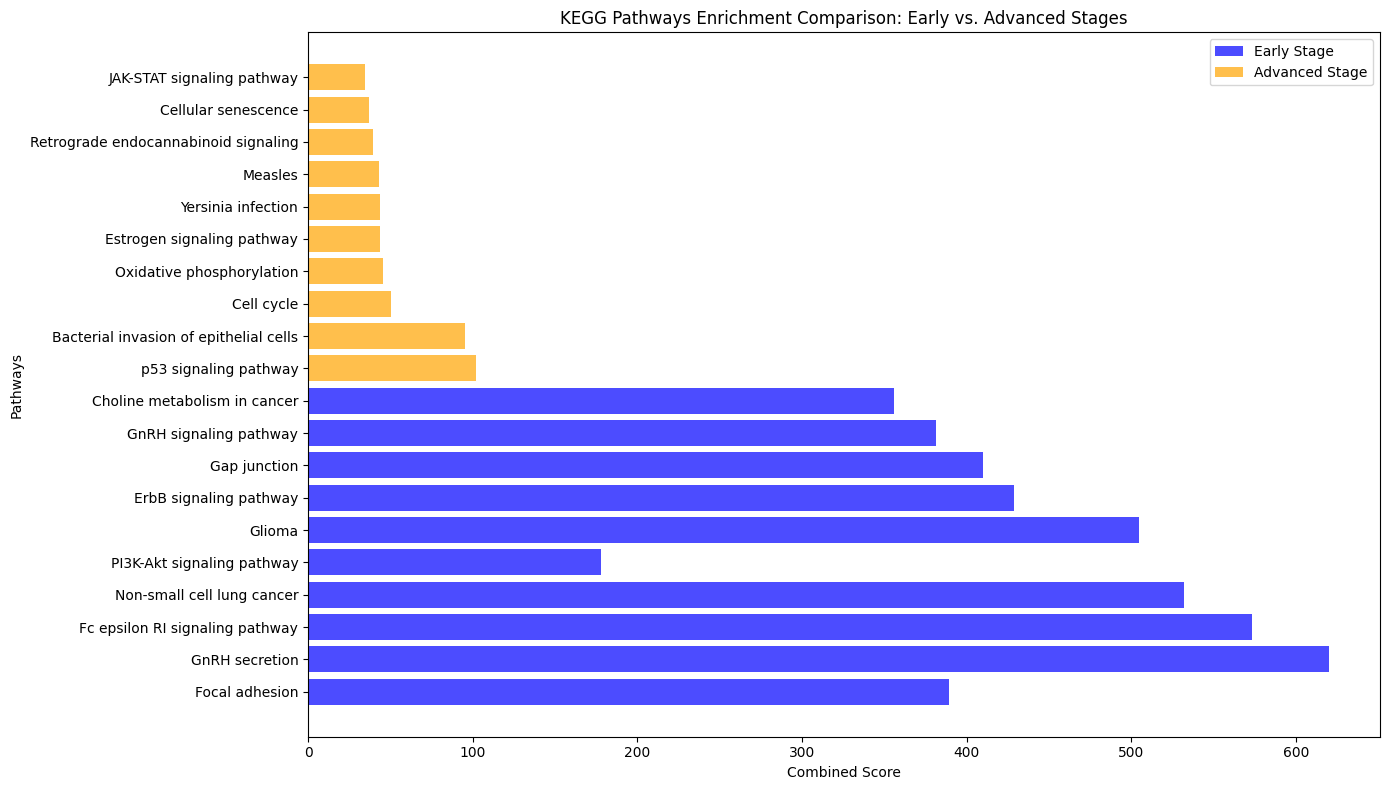

In [22]:
import gseapy as gp
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Define gene lists for early and advanced stages
early_genes = ["TMEM163", "DENND3", "SLC11A1", "TBC1D14", "ERC2", "GRB2", "SPATA6", "SLC2A5", "SPP1", "PRKCA"]
advanced_genes = ["FOXP1", "XIST", "CCND3", "ELMO1", "FKBP5", "DOCK5", "MS4A6A", "ND3", "RNF150", "NHSL1"]

# Step 2: Perform pathway enrichment analysis for KEGG pathways
print("Performing KEGG pathway enrichment analysis for Early Stage genes...")
early_kegg = gp.enrichr(gene_list=early_genes,
                        gene_sets="KEGG_2021_Human",  # Use KEGG pathways for human
                        organism='human',            # Organism name
                        outdir=None)                 # No output directory

print("Performing KEGG pathway enrichment analysis for Advanced Stage genes...")
advanced_kegg = gp.enrichr(gene_list=advanced_genes,
                           gene_sets="KEGG_2021_Human",
                           organism='human',
                           outdir=None)

# Step 3: Extract top pathways for visualization
early_kegg_top = early_kegg.results[['Term', 'Combined Score']].head(10)
advanced_kegg_top = advanced_kegg.results[['Term', 'Combined Score']].head(10)

# Step 4: Visualize KEGG pathways
plt.figure(figsize=(14, 8))

# Early stage pathways
plt.barh(early_kegg_top['Term'], early_kegg_top['Combined Score'], color='blue', alpha=0.7, label='Early Stage')

# Advanced stage pathways
plt.barh(advanced_kegg_top['Term'], advanced_kegg_top['Combined Score'], color='orange', alpha=0.7, label='Advanced Stage')

plt.xlabel("Combined Score")
plt.ylabel("Pathways")
plt.title("KEGG Pathways Enrichment Comparison: Early vs. Advanced Stages")
plt.legend()
plt.tight_layout()

plt.show()


### Pathway Insights

### KEGG Pathways (Early Stage):
1. Focal Adhesion (Combined Score: 388.99): Plays a critical role in cell migration and signaling, potentially linked to early neuroprotection and microglial activation. Associated genes: SPP1, PRKCA, GRB2. Indicates potential roles in cell adhesion and extracellular matrix signaling.

2. GnRH Secretion and Signaling (Combined Scores: 619.92 and 381.04):Highlights the involvement of hormonal signaling, which may influence inflammation and microglial functions in the early stage. Genes SPP1 and PRKCA are involved, hinting at neuroendocrine interactions.

3. Fc Epsilon RI Signaling (Combined Score: 573.09): Reflects immune activation, supporting the hypothesis of early-stage microglial neuroprotective mechanisms. Significant with PRKCA and GRB2, suggesting immune modulation.

4. PI3K-Akt Signaling (Combined Score: 177.83): Associated with cell survival and anti-apoptotic functions, crucial for protecting neurons in early Alzheimer's disease (AD). Includes SPP1, PRKCA, GRB2.

5. ErbB and Gap Junction Pathways (Combined Scores: 428.66 and 409.65): ErbB signaling influences cellular proliferation and survival, while gap junctions facilitate intercellular communication.




### KEGG Pathways (Advanced Stage):


1. p53 Signaling Pathway (Combined Score: 102.25): Strongly linked to apoptosis and neurotoxicity, signaling the progression to advanced disease stages.  Key gene CCND3.

2. Oxidative Phosphorylation and Cell Cycle (Combined Scores: 45.80 and 50.39): Indicates energy metabolism disruptions and impaired cell-cycle regulation, key factors in neurodegeneration.
- ND3 in Oxidative Phosphorylation suggests impaired mitochondrial function.
- Involvement of CCND3 in Cell Cycle highlights dysregulation in cell division processes during advanced stages.

3. Bacterial Invasion and Immune Dysfunction (Combined Score: 95.32): Suggests inflammatory pathways contributing to the advanced-stage neurotoxicity. ELMO1 suggests immune response shifts.

  Overall, these pathways reflect mechanisms related to cellular senescence, oxidative phosphorylation, and mitotic dysregulation. Reduced immune-related pathways suggest a shift toward disease progression and reduced neuroprotective signaling.

### Comparison
**Early Neuroprotection**: Pathways like PI3K-Akt, ERBB2, and focal adhesion reflect a neuroprotective environment aimed at maintaining neuronal survival and repair mechanisms.

**Advanced Disease Mechanisms**: Advanced-stage enrichment in pathways like p53 signaling and mitotic dysregulation reflects cellular damage, increased apoptosis, and metabolic dysfunction.



In [27]:
# List of validated Early and Late AD genes

# Step 1: Define gene lists for early and advanced stages
early_genes = ["TMEM163", "DENND3", "SLC11A1", "TBC1D14", "ERC2", "GRB2", "SPATA6", "SLC2A5", "SPP1", "PRKCA"]
advanced_genes = ["FOXP1", "XIST", "CCND3", "ELMO1", "FKBP5", "DOCK5", "MS4A6A", "ND3", "RNF150", "NHSL1"]

# Perform enrichment for Early AD genes
early_ad_enrichment = gp.enrichr(
    gene_list=early_genes,
    gene_sets='KEGG_2021_Human',
    organism='Human'
)
early_ad_enrichment.results.head()

Gene_set                             Term Overlap   P-value  \
0  KEGG_2021_Human                   Focal adhesion   3/201  0.000114   
1  KEGG_2021_Human                   GnRH secretion    2/64  0.000446   
2  KEGG_2021_Human  Fc epsilon RI signaling pathway    2/68  0.000504   
3  KEGG_2021_Human       Non-small cell lung cancer    2/72  0.000564   
4  KEGG_2021_Human       PI3K-Akt signaling pathway   3/354  0.000602   

   Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
0          0.010308            0                     0   42.839827   
1          0.010308            0                     0   80.354839   
2          0.010308            0                     0   75.469697   
3          0.010308            0                     0   71.142857   
4          0.010308            0                     0   23.979243   

   Combined Score            Genes  
0      388.987276  SPP1;PRKCA;GRB2  
1      619.922544       SPP1;PRKCA  
2      573.093987       PRKCA;GRB2  
3      532.121352       PRKCA;GRB2  
4      177.829494  SPP1;PRKCA;GRB2

In [28]:
# Perform enrichment for Early AD genes
advanced_ad_enrichment = gp.enrichr(
    gene_list=advanced_genes,
    gene_sets='KEGG_2021_Human',
    organism='Human'
)
advanced_ad_enrichment.results.head()

Gene_set                                    Term Overlap   P-value  \
0  KEGG_2021_Human                   p53 signaling pathway    1/73  0.035914   
1  KEGG_2021_Human  Bacterial invasion of epithelial cells    1/77  0.037848   
2  KEGG_2021_Human                              Cell cycle   1/124  0.060311   
3  KEGG_2021_Human               Oxidative phosphorylation   1/133  0.064559   
4  KEGG_2021_Human              Estrogen signaling pathway   1/137  0.066441   

   Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
0          0.161942            0                     0   30.737654   
1          0.161942            0                     0   29.114035   
2          0.161942            0                     0   17.946703   
3          0.161942            0                     0   16.715488   
4          0.161942            0                     0   16.220588   

   Combined Score  Genes  
0      102.252718  CCND3  
1       95.324547  ELMO1  
2       50.398535  CCND3  
3       45.803453    ND3  
4       43.981210  FKBP5

## Step 5.2 Perform pathway analysis specifically for APOE4 carriers vs. non-carriers


Performing KEGG_2021_Human pathway enrichment for APOE4 Carriers - Early Stage genes...
Performing KEGG_2021_Human pathway enrichment for APOE4 Carriers - Advanced Stage genes...
Performing KEGG_2021_Human pathway enrichment for Non-Carriers - Early Stage genes...
Performing KEGG_2021_Human pathway enrichment for Non-Carriers - Advanced Stage genes...


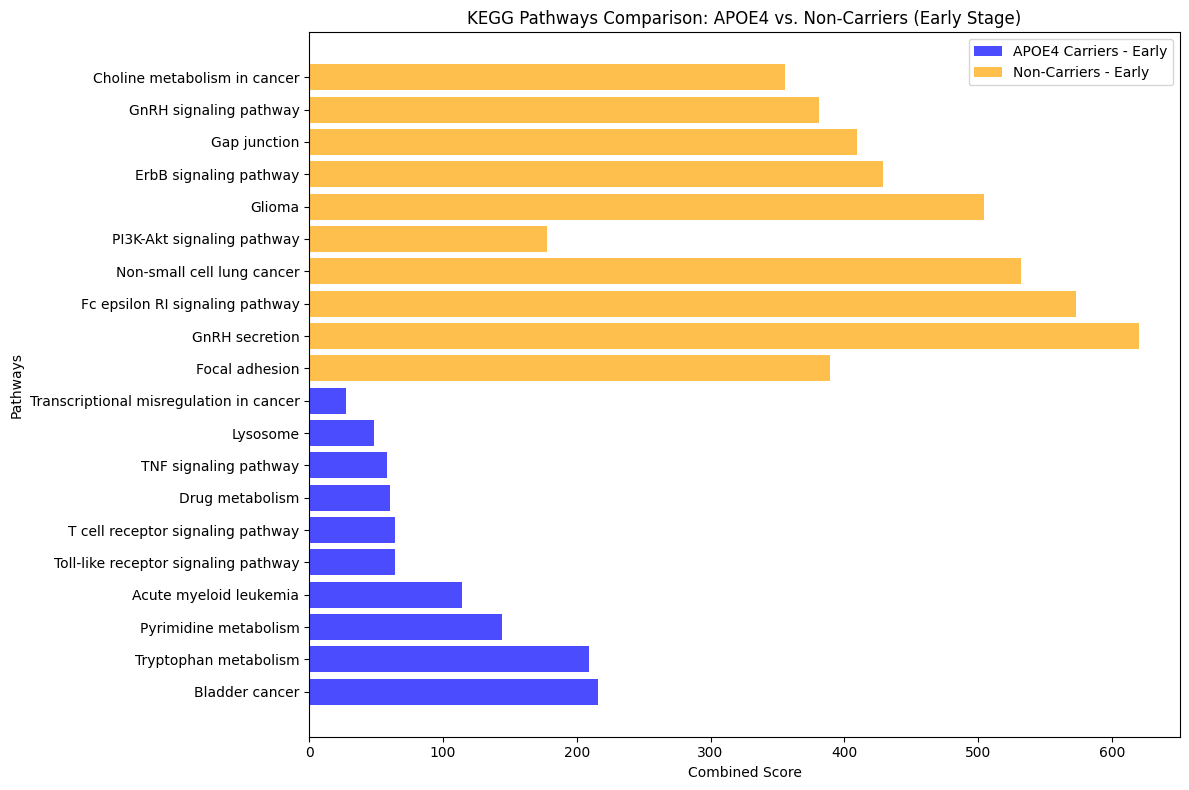

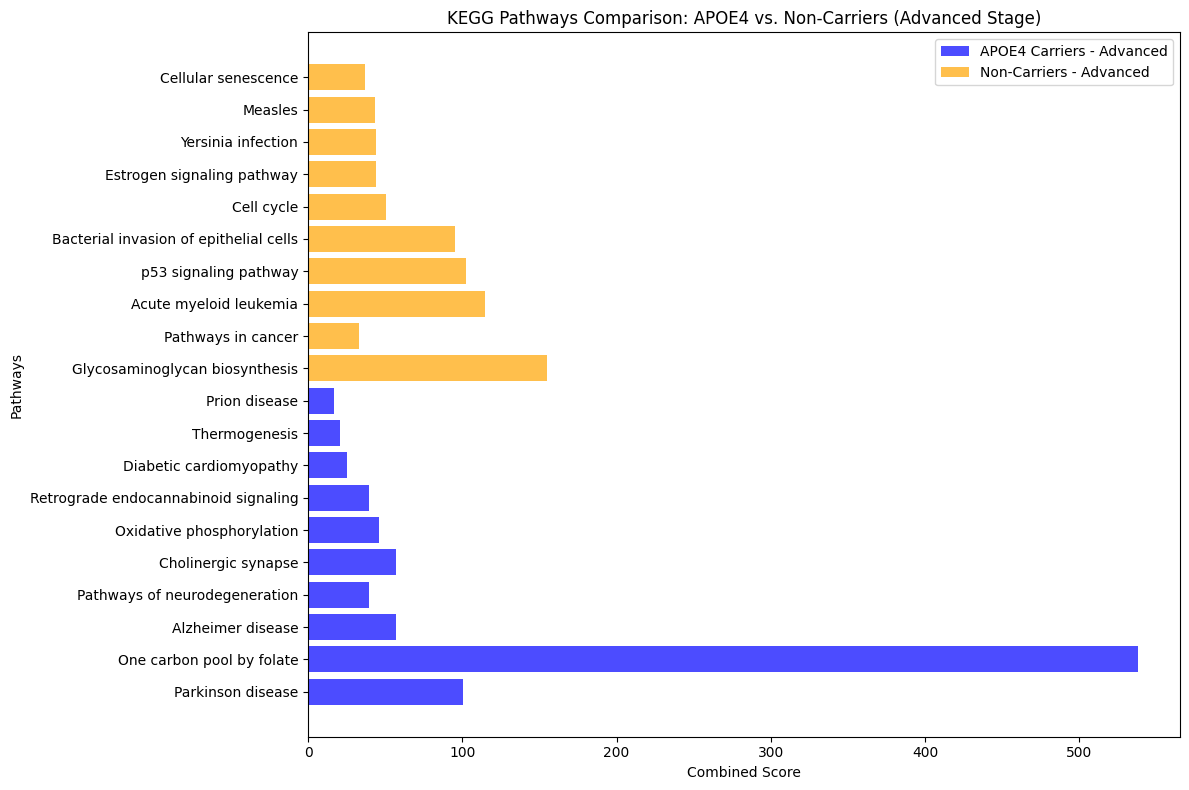

In [29]:
import gseapy as gp
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Define gene lists
apoe4_carrier_genes_early = ["SLC11A1", "NEAT1", "TBC1D14", "CD163L1", "CD163", "MALAT1", "ZBTB16", "MAP3K8", "TYMP", "KYNU"]
apoe4_carrier_genes_advanced = ["HS3ST4", "SYNDIG1", "MTHFD1L", "KCNQ3", "SNCA", "SFMBT2", "ND3", "GLDN", "DSCAM", "LOC285626"]
non_carrier_genes_early = ["TMEM163", "DENND3", "SLC11A1", "TBC1D14", "SPATA6", "SLC2A5", "SPP1", "PRKCA", "UTY", "GRB2"]
non_carrier_genes_advanced = ["XIST", "MS4A6A", "CCND3", "DOCK5", "FKBP5", "RNF150", "ZBTB16", "FOXP1", "ELMO1", "CSGALNACT1"]

# Step 2: Perform pathway enrichment analysis
def perform_enrichment(gene_list, gene_set, stage, group):
    print(f"Performing {gene_set} pathway enrichment for {group} - {stage} Stage genes...")
    enrichment_results = gp.enrichr(
        gene_list=gene_list,
        gene_sets=gene_set,
        organism='human',
        outdir=None
    )
    return enrichment_results

# APOE4 carriers
apoe4_early_kegg = perform_enrichment(apoe4_carrier_genes_early, "KEGG_2021_Human", "Early", "APOE4 Carriers")
apoe4_advanced_kegg = perform_enrichment(apoe4_carrier_genes_advanced, "KEGG_2021_Human", "Advanced", "APOE4 Carriers")

# Non-carriers
non_carrier_early_kegg = perform_enrichment(non_carrier_genes_early, "KEGG_2021_Human", "Early", "Non-Carriers")
non_carrier_advanced_kegg = perform_enrichment(non_carrier_genes_advanced, "KEGG_2021_Human", "Advanced", "Non-Carriers")

# Step 3: Extract top pathways for visualization
def extract_top_pathways(results, n=10):
    return results.results[['Term', 'Adjusted P-value', 'Combined Score', 'Genes']].head(n)

apoe4_early_top = extract_top_pathways(apoe4_early_kegg)
apoe4_advanced_top = extract_top_pathways(apoe4_advanced_kegg)
non_carrier_early_top = extract_top_pathways(non_carrier_early_kegg)
non_carrier_advanced_top = extract_top_pathways(non_carrier_advanced_kegg)

# Step 4: Visualize results
def plot_comparison(pathways1, pathways2, label1, label2, title):
    plt.figure(figsize=(12, 8))
    plt.barh(pathways1['Term'], pathways1['Combined Score'], color='blue', alpha=0.7, label=label1)
    plt.barh(pathways2['Term'], pathways2['Combined Score'], color='orange', alpha=0.7, label=label2)
    plt.xlabel("Combined Score")
    plt.ylabel("Pathways")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Compare APOE4 carriers and non-carriers for Early and Advanced stages
plot_comparison(apoe4_early_top, non_carrier_early_top, "APOE4 Carriers - Early", "Non-Carriers - Early", "KEGG Pathways Comparison: APOE4 vs. Non-Carriers (Early Stage)")
plot_comparison(apoe4_advanced_top, non_carrier_advanced_top, "APOE4 Carriers - Advanced", "Non-Carriers - Advanced", "KEGG Pathways Comparison: APOE4 vs. Non-Carriers (Advanced Stage)")


### Key Findings - APOE4 vs. Non-Carriers Pathway Enrichment
**Early Stage:**

**Non-Carriers:** Enriched pathways like Focal adhesion, PI3K-Akt signaling, and ErbB signaling suggest systemic signaling, adhesion, and growth factor interactions. Immune and hormonal regulation pathways (e.g., Fc epsilon RI signaling) highlight early neuroprotective mechanisms.

**APOE4 Carriers:** Show heightened metabolic (e.g., Tryptophan metabolism) and immune activation (e.g., Toll-like receptor signaling, TNF signaling), indicating early inflammatory and proteostasis disruptions.

**Advanced Stage:**

**Non-Carriers:** Enriched pathways (Cellular senescence, p53 signaling) highlight aging, DNA damage responses, and extracellular matrix dysfunctions.

**APOE4 Carriers:** Strong enrichment in neurodegenerative pathways (Alzheimer’s disease, Parkinson’s disease) and neurotransmitter-specific dysfunctions (Cholinergic synapse) suggest accelerated progression and cognitive decline.

### Conclusion:

- APOE4 carriers exhibit earlier metabolic and immune dysregulation, with rapid transition to neurodegenerative pathways in advanced stages
- Non-carriers rely on compensatory mechanisms like cell cycle and senescence-related pathways that delay neurotoxicity.


In [32]:
import gseapy as gp
import pandas as pd

# Step 1: Define gene lists for APOE4 carriers and non-carriers
apoe4_genes = ["SLC11A1", "TBC1D14", "NEAT1", "CD163", "ZBTB16", "KYNU", "MAP3K8", "MALAT1", "TYMP"]
non_carrier_genes = ["TMEM163", "DENND3", "PRKCA", "SPP1", "SLC2A5", "GRB2", "HIVEP3", "ERC2"]

# Step 2: Perform pathway enrichment analysis for APOE4 carriers (KEGG)
apoe4_kegg = gp.enrichr(gene_list=apoe4_genes,
                        gene_sets="KEGG_2021_Human",
                        organism="human",
                        outdir=None)

non_carrier_kegg = gp.enrichr(gene_list=non_carrier_genes,
                              gene_sets="KEGG_2021_Human",
                              organism="human",
                              outdir=None)

# Display top enriched pathways
print("\nTop KEGG pathways for APOE4 genes:")
print(apoe4_kegg.results[['Term', 'Adjusted P-value', 'Overlap', 'Combined Score']].head(10))

print("\nTop KEGG pathways for Non-carrier genes:")
print(non_carrier_kegg.results[['Term', 'Adjusted P-value', 'Overlap', 'Combined Score']].head(10))



Top KEGG pathways for APOE4 genes:
                                      Term  Adjusted P-value Overlap  \
0                           Bladder cancer          0.073943    1/41   
1                    Tryptophan metabolism          0.073943    1/42   
2                    Pyrimidine metabolism          0.073943    1/56   
3                   Acute myeloid leukemia          0.073943    1/67   
4     Toll-like receptor signaling pathway          0.073943   1/104   
5        T cell receptor signaling pathway          0.073943   1/104   
6                          Drug metabolism          0.073943   1/108   
7                    TNF signaling pathway          0.073943   1/112   
8                                 Lysosome          0.074877   1/128   
9  Transcriptional misregulation in cancer          0.099805   1/192   

   Combined Score  
0      249.430818  
1      241.881398  
2      167.277077  
3      132.635751  
4       74.397649  
5       74.397649  
6       70.743874  
7       67.

Performing KEGG pathway enrichment for APOE4 carriers...
Performing KEGG pathway enrichment for Non-carriers...
Top KEGG pathways for APOE4 Early Stage Genes:
                                   Term  Adjusted P-value  Combined Score  \
0                        Bladder cancer          0.050235      353.335453   
1                 Pyrimidine metabolism          0.050235      238.076678   
2  Toll-like receptor signaling pathway          0.050235      107.130206   
3     T cell receptor signaling pathway          0.050235      107.130206   
4                       Drug metabolism          0.050235      101.954141   

    Genes  
0    TYMP  
1    TYMP  
2  MAP3K8  
3  MAP3K8  
4    TYMP  

Top KEGG pathways for APOE4 Advanced Stage Genes:
                            Term  Adjusted P-value  Combined Score Genes
0              Parkinson disease          0.113252       55.765425  SNCA
1              Alzheimer disease          0.113252       32.267987  SNCA
2  Pathways of neurodegeneration    

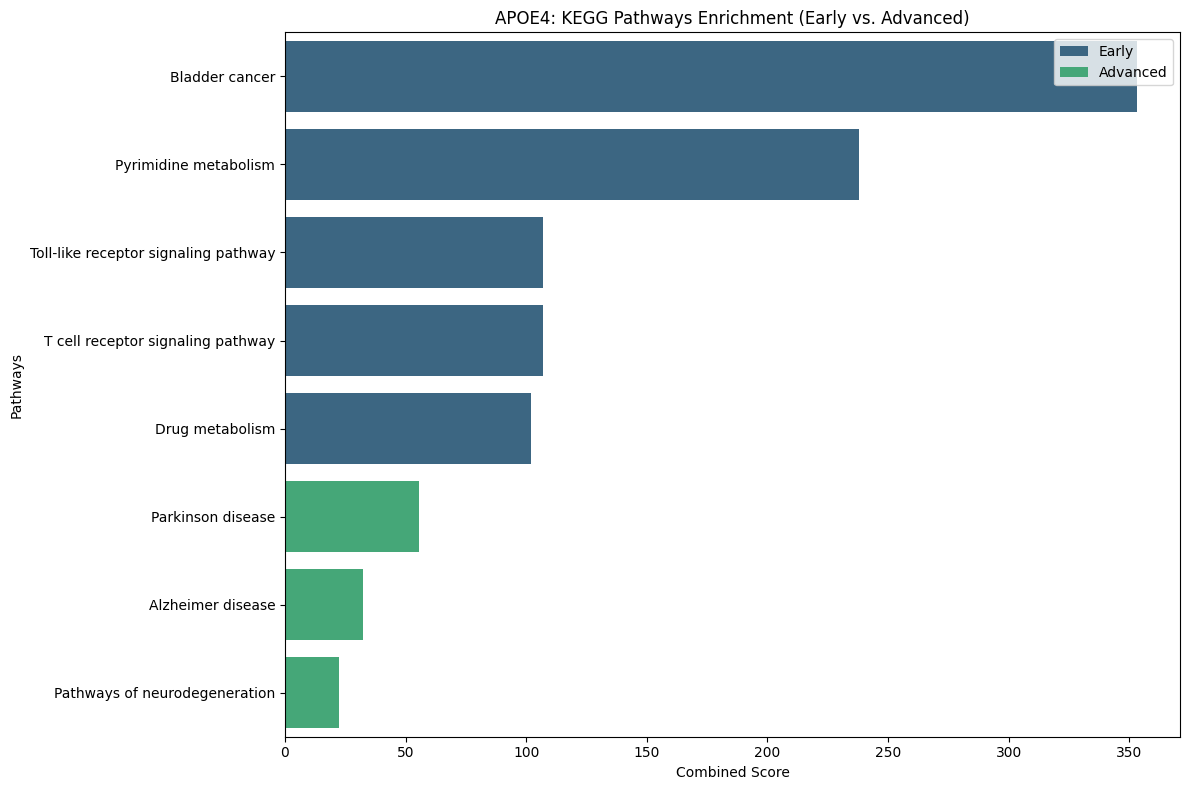

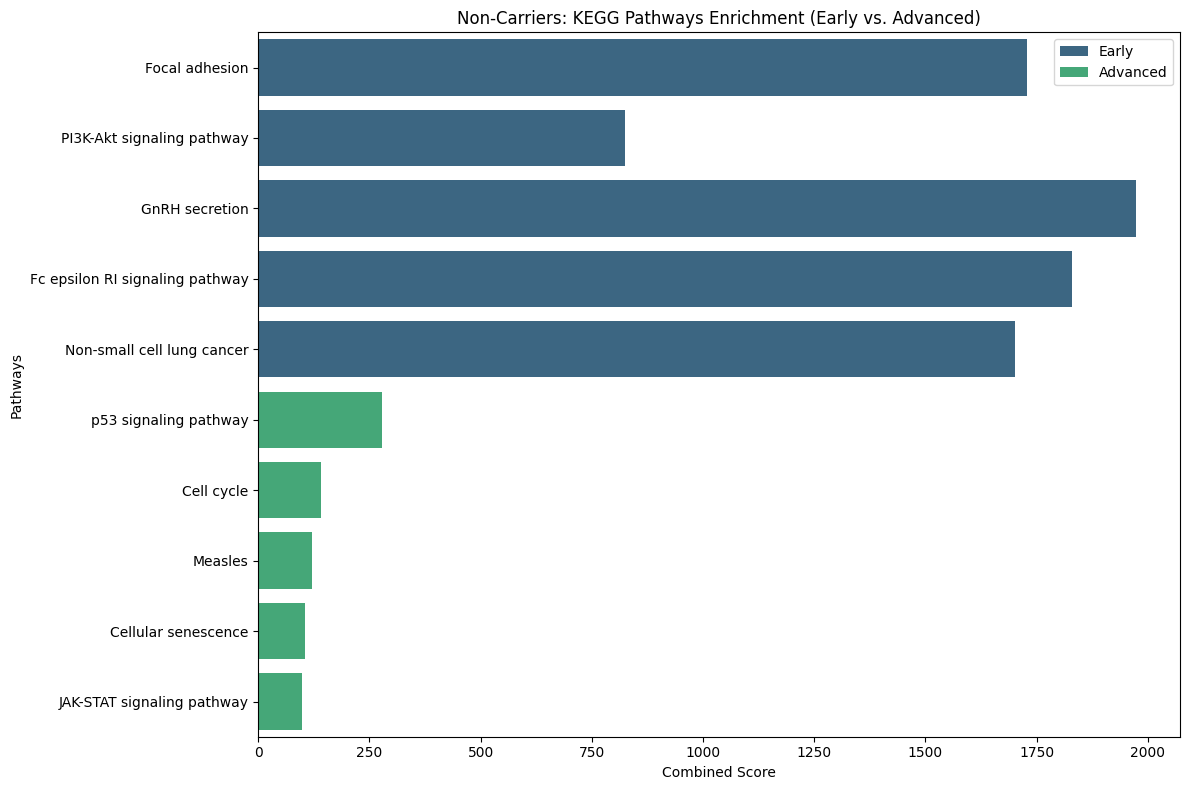

In [31]:
import gseapy as gp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Define gene lists for APOE4 carriers vs. non-carriers
apoe4_early_genes = ["SLC11A1", "NEAT1", "TBC1D14", "CD163L1", "MALAT1", "MAP3K8", "TYMP"]
apoe4_advanced_genes = ["HS3ST4", "SYNDIG1", "SNCA", "GLDN", "DSCAM"]

non_carrier_early_genes = ["TMEM163", "DENND3", "PRKCA", "SPP1", "GRB2"]
non_carrier_advanced_genes = ["XIST", "CCND3", "DOCK5", "RNF150", "NHSL1"]

# Step 2: Perform pathway enrichment for APOE4 carriers and non-carriers
print("Performing KEGG pathway enrichment for APOE4 carriers...")
apoe4_early_kegg = gp.enrichr(
    gene_list=apoe4_early_genes,
    gene_sets="KEGG_2021_Human",
    organism="human",
    outdir=None,
)

apoe4_advanced_kegg = gp.enrichr(
    gene_list=apoe4_advanced_genes,
    gene_sets="KEGG_2021_Human",
    organism="human",
    outdir=None,
)

print("Performing KEGG pathway enrichment for Non-carriers...")
non_carrier_early_kegg = gp.enrichr(
    gene_list=non_carrier_early_genes,
    gene_sets="KEGG_2021_Human",
    organism="human",
    outdir=None,
)

non_carrier_advanced_kegg = gp.enrichr(
    gene_list=non_carrier_advanced_genes,
    gene_sets="KEGG_2021_Human",
    organism="human",
    outdir=None,
)

# Step 3: Extract and compare key pathways
def extract_top_pathways(results, top_n=5):
    """Extract top pathways from GSEA results."""
    return results.results[["Term", "Adjusted P-value", "Combined Score", "Genes"]].head(top_n)

apoe4_early_top = extract_top_pathways(apoe4_early_kegg)
apoe4_advanced_top = extract_top_pathways(apoe4_advanced_kegg)
non_carrier_early_top = extract_top_pathways(non_carrier_early_kegg)
non_carrier_advanced_top = extract_top_pathways(non_carrier_advanced_kegg)

# Display top pathways for APOE4 carriers vs. non-carriers
print("Top KEGG pathways for APOE4 Early Stage Genes:")
print(apoe4_early_top)
print("\nTop KEGG pathways for APOE4 Advanced Stage Genes:")
print(apoe4_advanced_top)
print("\nTop KEGG pathways for Non-Carriers Early Stage Genes:")
print(non_carrier_early_top)
print("\nTop KEGG pathways for Non-Carriers Advanced Stage Genes:")
print(non_carrier_advanced_top)

# Step 4: Visualize pathway comparison
def visualize_pathways_comparison(pathways_early, pathways_advanced, title):
    """Visualize pathway comparison between early and advanced stages."""
    combined_data = pd.concat(
        [
            pathways_early.assign(Stage="Early"),
            pathways_advanced.assign(Stage="Advanced"),
        ]
    )
    plt.figure(figsize=(12, 8))
    sns.barplot(
        data=combined_data,
        x="Combined Score",
        y="Term",
        hue="Stage",
        palette="viridis",
    )
    plt.title(title)
    plt.xlabel("Combined Score")
    plt.ylabel("Pathways")
    plt.legend(loc="upper right")
    plt.tight_layout()
    plt.show()

# Visualize KEGG pathway enrichment for APOE4 carriers and non-carriers
visualize_pathways_comparison(apoe4_early_top, apoe4_advanced_top, "APOE4: KEGG Pathways Enrichment (Early vs. Advanced)")
visualize_pathways_comparison(non_carrier_early_top, non_carrier_advanced_top, "Non-Carriers: KEGG Pathways Enrichment (Early vs. Advanced)")

# Step 5: Investigate temporal changes (Optional with time-series data)
# Assuming you have time-series data for pathway dynamics:
# time_series_data = pd.read_csv("pathway_dynamics.csv") # Replace with actual data
# sns.lineplot(data=time_series_data, x="Time", y="Pathway Activity", hue="Pathway")
# plt.title("Temporal Changes in Pathway Dynamics")
# plt.show()



### Insights: APOE 4

**Early Stage**: APOE4 carriers emphasize metabolism (TYMP) and immune signaling (MAP3K8), while non-carriers highlight adhesion (SPP1, PRKCA) and broad signaling pathways.

This suggests metabolic priming in APOE4 carriers versus broader immune dysregulation in non-carriers.

**Advanced Stage**: APOE4 carriers focus on neurodegeneration-specific pathways (SNCA), such as Alzheimer’s and Parkinson’s disease.

Non-carriers emphasize cell cycle and inflammatory pathways (CCND3), suggesting a less neurodegeneration-centric progression.

## Step 6.1 Integrared Disease Stages

Early Stage AD:

*  Use Cognitie status: ‘No dementia’ with signs of mild cognitive impairment.
*  Braak stage: Lower stages (e.g., ‘Braak 0’ to ‘Braak III’).

Number of cells in early stage: 2594
Number of cells in late stage: 23413


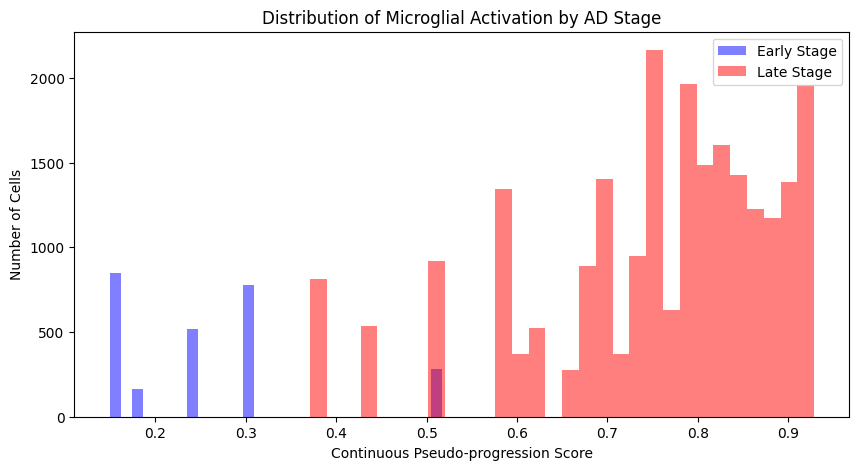

T-statistic: -212.0989479191894
P-value: 0.0
There is a statistically significant difference in microglial activation between early and late stages.


In [ ]:

# Define activation metric column name
activation_metric = 'Continuous Pseudo-progression Score'  # Adjust if a different metric is relevant

# Define early and late stage conditions based on revised criteria
early_stage_conditions = (
    (adata_mtg.obs['ADNC'] == 'Low') &
    (adata_mtg.obs['Braak stage'].isin(['Braak 0', 'Braak II', 'Braak III'])) &
    (adata_mtg.obs['Thal phase'].isin(['Thal 0', 'Thal 1', 'Thal 2'])) &
    (adata_mtg.obs['CERAD score'].isin(['Sparse', 'Absent']))
)

late_stage_conditions = (
    (adata_mtg.obs['ADNC'].isin(['Intermediate', 'High'])) &
    (adata_mtg.obs['Braak stage'].isin(['Braak IV', 'Braak V', 'Braak VI'])) &
    (adata_mtg.obs['Thal phase'].isin(['Thal 3', 'Thal 4', 'Thal 5'])) &
    (adata_mtg.obs['CERAD score'].isin(['Moderate', 'Frequent']))
)

# Filter data for early and late stages based on the revised criteria
early_stage_data = adata_mtg.obs[early_stage_conditions][activation_metric].dropna()
late_stage_data = adata_mtg.obs[late_stage_conditions][activation_metric].dropna()

# Display counts for each group
print("Number of cells in early stage:", early_stage_data.shape[0])
print("Number of cells in late stage:", late_stage_data.shape[0])

# Visualize the activation metric distribution for early and late stages
plt.figure(figsize=(10, 5))
plt.hist(early_stage_data, bins=30, alpha=0.5, label='Early Stage', color='blue')
plt.hist(late_stage_data, bins=30, alpha=0.5, label='Late Stage', color='red')
plt.xlabel(activation_metric)
plt.ylabel('Number of Cells')
plt.title('Distribution of Microglial Activation by AD Stage')
plt.legend()
plt.show()

# Perform a t-test to compare activation between early and late stages
t_stat, p_value = stats.ttest_ind(early_stage_data, late_stage_data, equal_var=False)

# Output results
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

if p_value < 0.05:
    print("There is a statistically significant difference in microglial activation between early and late stages.")
else:
    print("There is no statistically significant difference in microglial activation between early and late stages.")


Late Stage AD:


*   Cognitive status: ‘Dementia’.
*   Braak stage: Higher stages (e.g., ‘Braak IV’ to ‘Braak VI’).


## Step 6.2. Group by APOE4 Status:

APOE4 Carriers:
*   APOE4 status: ‘Y’.




In [ ]:
# Define new groupings based on Braak stage, Thal phase, and ADNC
# Early Stage: ADNC = 'Low' OR (Braak stage ≤ III OR Thal phase ≤ 2)
# Late Stage: ADNC = 'Intermediate' or 'High' OR (Braak stage ≥ IV OR Thal phase ≥ 3)

# Filter based on Braak stage, Thal phase, and ADNC for APOE4 Carriers (Early and Late stages)
early_stage_carriers = adata_mtg_filtered.obs[
    (adata_mtg_filtered.obs['APOE4 status'] == 'Y') &
    (
        (adata_mtg_filtered.obs['ADNC'] == 'Low') |
        (adata_mtg_filtered.obs['Braak stage'].isin(['Braak 0', 'Braak II', 'Braak III'])) |
        (adata_mtg_filtered.obs['Thal phase'].isin(['Thal 0', 'Thal 1', 'Thal 2']))
    )
]['Continuous Pseudo-progression Score'].dropna()

late_stage_carriers = adata_mtg_filtered.obs[
    (adata_mtg_filtered.obs['APOE4 status'] == 'Y') &
    (
        adata_mtg_filtered.obs['ADNC'].isin(['Intermediate', 'High']) |
        (adata_mtg_filtered.obs['Braak stage'].isin(['Braak IV', 'Braak V', 'Braak VI'])) |
        (adata_mtg_filtered.obs['Thal phase'].isin(['Thal 3', 'Thal 4', 'Thal 5']))
    )
]['Continuous Pseudo-progression Score'].dropna()

# Filter based on Braak stage, Thal phase, and ADNC for APOE4 Non-Carriers (Early and Late stages)
early_stage_non_carriers = adata_mtg_filtered.obs[
    (adata_mtg_filtered.obs['APOE4 status'] == 'N') &
    (
        (adata_mtg_filtered.obs['ADNC'] == 'Low') |
        (adata_mtg_filtered.obs['Braak stage'].isin(['Braak 0', 'Braak II', 'Braak III'])) |
        (adata_mtg_filtered.obs['Thal phase'].isin(['Thal 0', 'Thal 1', 'Thal 2']))
    )
]['Continuous Pseudo-progression Score'].dropna()

late_stage_non_carriers = adata_mtg_filtered.obs[
    (adata_mtg_filtered.obs['APOE4 status'] == 'N') &
    (
        adata_mtg_filtered.obs['ADNC'].isin(['Intermediate', 'High']) |
        (adata_mtg_filtered.obs['Braak stage'].isin(['Braak IV', 'Braak V', 'Braak VI'])) |
        (adata_mtg_filtered.obs['Thal phase'].isin(['Thal 3', 'Thal 4', 'Thal 5']))
    )
]['Continuous Pseudo-progression Score'].dropna()

# Display cell counts for each group
print(f"APOE4 Carriers - Early Stage Cells: {len(early_stage_carriers)}")
print(f"APOE4 Carriers - Late Stage Cells: {len(late_stage_carriers)}")
print(f"APOE4 Non-Carriers - Early Stage Cells: {len(early_stage_non_carriers)}")
print(f"APOE4 Non-Carriers - Late Stage Cells: {len(late_stage_non_carriers)}")

# Perform t-tests for APOE4 carriers and non-carriers separately
if len(early_stage_carriers) > 0 and len(late_stage_carriers) > 0:
    t_stat_carriers, p_val_carriers = ttest_ind(early_stage_carriers, late_stage_carriers, equal_var=False)
    print(f"T-statistic for APOE4 Carriers (Early vs Late): {t_stat_carriers}")
    print(f"P-value for APOE4 Carriers (Early vs Late): {p_val_carriers}")
else:
    print("Insufficient data for APOE4 Carriers in either early or late stage.")

if len(early_stage_non_carriers) > 0 and len(late_stage_non_carriers) > 0:
    t_stat_non_carriers, p_val_non_carriers = ttest_ind(early_stage_non_carriers, late_stage_non_carriers, equal_var=False)
    print(f"T-statistic for APOE4 Non-Carriers (Early vs Late): {t_stat_non_carriers}")
    print(f"P-value for APOE4 Non-Carriers (Early vs Late): {p_val_non_carriers}")
else:
    print("Insufficient data for APOE4 Non-Carriers in either early or late stage.")


APOE4 Carriers - Early Stage Cells: 637
APOE4 Carriers - Late Stage Cells: 11455
APOE4 Non-Carriers - Early Stage Cells: 12015
APOE4 Non-Carriers - Late Stage Cells: 23879
T-statistic for APOE4 Carriers (Early vs Late): -25.553977658488918
P-value for APOE4 Carriers (Early vs Late): 6.42543815215523e-101
T-statistic for APOE4 Non-Carriers (Early vs Late): -102.67992236222808
P-value for APOE4 Non-Carriers (Early vs Late): 0.0


### Key Findings

**APOE4 Carriers:**

The significant difference in microglial activation between early and late stages for APOE4 carriers supports the hypothesis that microglial activation changes as Alzheimer's progresses in individuals with the APOE4 gene. Given the negative t-statistic, this might indicate a shift in the nature of microglial activation—potentially from a protective role in the early stages to a more harmful or neurotoxic role in the later stages.
APOE4 Non-Carriers:

Similarly, the significant difference in microglial activation between early and late stages for APOE4 non-carriers suggests that this shift in microglial activity is not exclusive to APOE4 carriers. However, the larger t-statistic in non-carriers might imply a more pronounced change in microglial activation across stages for those without the APOE4 gene, or simply that there’s a consistent progression in microglial activation as the disease advances regardless of APOE4 status.

**Conclusion:**
The results support the hypothesis that microglial activation shifts between early and late stages in Alzheimer’s disease. However, the shift occurs in both APOE4 carriers and non-carriers, indicating that while APOE4 may influence Alzheimer's progression, changes in microglial activation between early and late stages are a broader characteristic of the disease progression and not limited solely to APOE4 carriers.

**Further Analysis:**
To fully validate these findings and understand the nuances, further statistical tests or adjustments might be needed to control for additional variables or confirm the biological implications of these observed differences in microglial activation across Alzheimer’s stages.

# ML Model

<ipython-input-23-32ba0838e4e4>:21: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['Stage'] = adata.obs['Braak stage'].apply(lambda x: 0 if x in ['Braak 0', 'Braak II', 'Braak III'] else 1)  # 0 = Early, 1 = Late



Classification Report for APOE4 Carriers:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      3234
           1       0.98      0.99      0.98      3257

    accuracy                           0.98      6491
   macro avg       0.98      0.98      0.98      6491
weighted avg       0.98      0.98      0.98      6491

Top genes associated with stage progression for APOE4 Carriers:
['ENSG00000105697' 'ENSG00000105835' 'ENSG00000204388' 'ENSG00000204389'
 'ENSG00000249738' 'ENSG00000152128' 'ENSG00000124491' 'ENSG00000198840'
 'ENSG00000177575' 'ENSG00000177675']


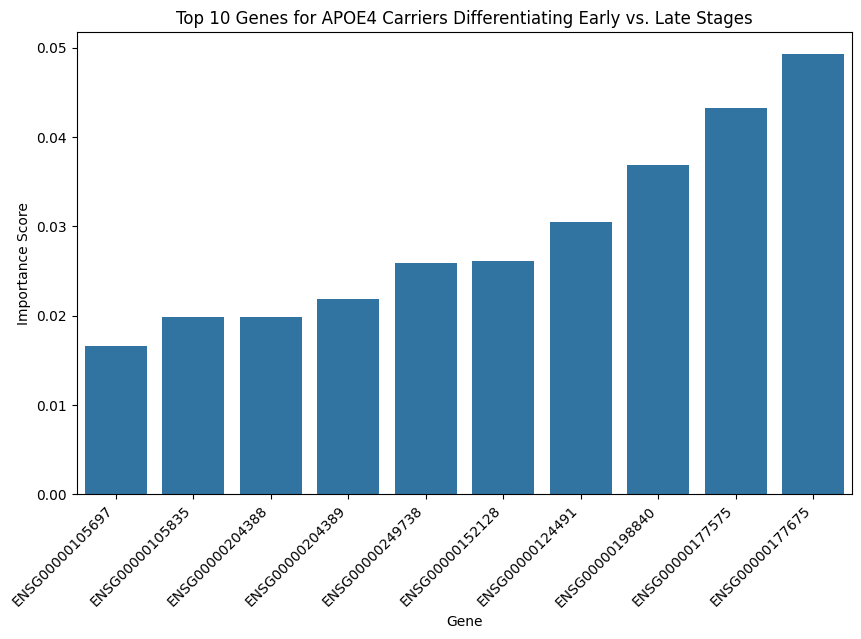


Classification Report for APOE4 Non-Carriers:
              precision    recall  f1-score   support

           0       0.95      0.88      0.91      6581
           1       0.89      0.95      0.92      6539

    accuracy                           0.92     13120
   macro avg       0.92      0.92      0.91     13120
weighted avg       0.92      0.92      0.91     13120

Top genes associated with stage progression for APOE4 Non-Carriers:
['ENSG00000115956' 'ENSG00000204389' 'ENSG00000118785' 'ENSG00000231535'
 'ENSG00000176728' 'ENSG00000120694' 'ENSG00000105697' 'ENSG00000198840'
 'ENSG00000059804' 'ENSG00000152128']


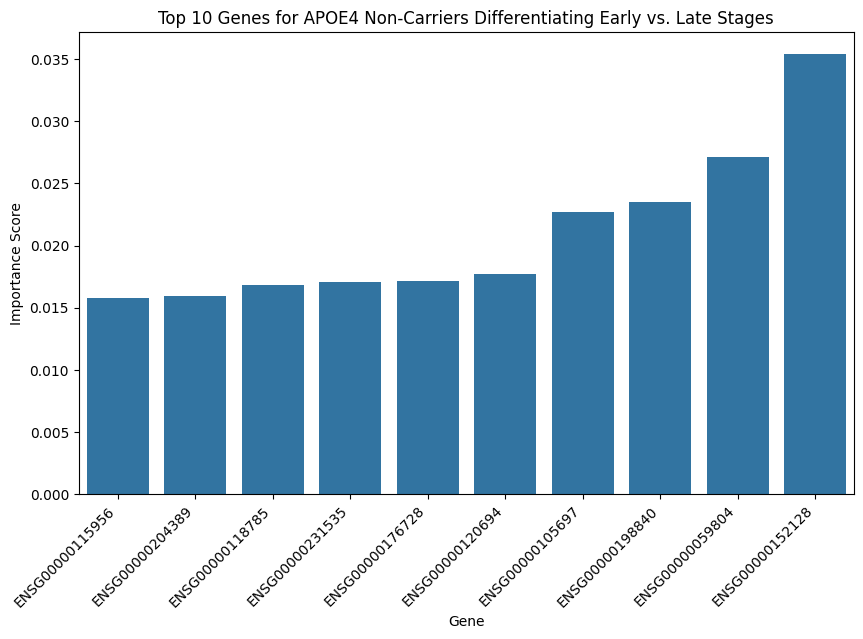

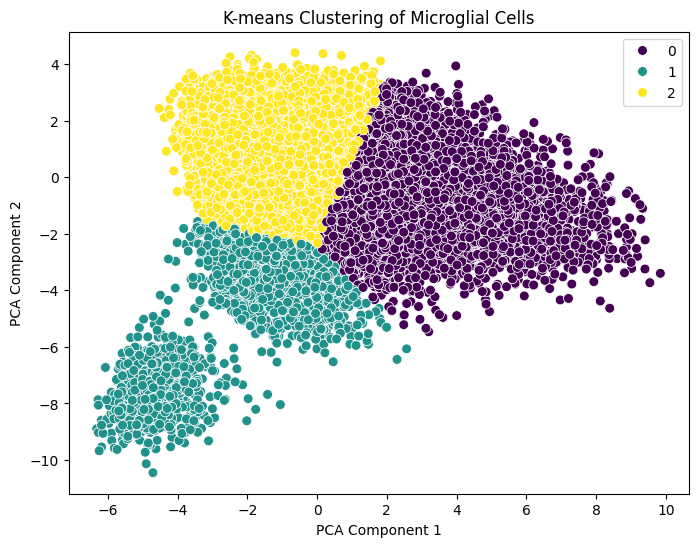

In [ ]:
# Step 1: Load and Filter the Dataset
adata = adata_mtg_filtered  # Assuming 'adata_mtg_filtered' is pre-loaded with the necessary data

# Step 2: Select highly variable genes (feature selection)
sc.pp.highly_variable_genes(adata, n_top_genes=300)
adata = adata[:, adata.var['highly_variable']]

# Step 3: Define early and late stage groups based on Braak stages (excluding 'Reference')
adata = adata[adata.obs['Braak stage'] != 'Reference']
adata.obs['Stage'] = adata.obs['Braak stage'].apply(lambda x: 0 if x in ['Braak 0', 'Braak II', 'Braak III'] else 1)  # 0 = Early, 1 = Late

# Step 4: Split data for APOE4 carriers and non-carriers
carriers = adata[adata.obs['APOE4 status'] == 'Y']
non_carriers = adata[adata.obs['APOE4 status'] == 'N']

# Step 5: Prepare data and labels for classification
def prepare_data(adata):
    X = adata.X.toarray()  # Assuming sparse matrix format, convert to dense if needed
    y = adata.obs['Stage'].values
    return X, y

X_carriers, y_carriers = prepare_data(carriers)
X_non_carriers, y_non_carriers = prepare_data(non_carriers)

# Step 6: Address Class Imbalance Using SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_carriers_resampled, y_carriers_resampled = smote.fit_resample(X_carriers, y_carriers)
X_non_carriers_resampled, y_non_carriers_resampled = smote.fit_resample(X_non_carriers, y_non_carriers)

# Step 7: Train-Test Split
X_train_carriers, X_test_carriers, y_train_carriers, y_test_carriers = train_test_split(X_carriers_resampled, y_carriers_resampled, test_size=0.3, random_state=42)
X_train_non_carriers, X_test_non_carriers, y_train_non_carriers, y_test_non_carriers = train_test_split(X_non_carriers_resampled, y_non_carriers_resampled, test_size=0.3, random_state=42)

# Step 8: Train Random Forest Classifier with Balanced Class Weights
def train_evaluate_rf(X_train, X_test, y_train, y_test, label):
    class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

    rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight=class_weights_dict)
    rf.fit(X_train, y_train)

    # Predictions and Evaluation
    y_pred = rf.predict(X_test)
    print(f"\nClassification Report for {label}:")
    print(classification_report(y_test, y_pred))

    # Feature importance
    feature_importances = rf.feature_importances_
    important_genes = np.array(adata.var_names)[np.argsort(feature_importances)[-10:]]  # Top 10 genes
    print(f"Top genes associated with stage progression for {label}:")
    print(important_genes)

    # Plot feature importance for top genes
    plt.figure(figsize=(10, 6))
    sns.barplot(x=important_genes, y=feature_importances[np.argsort(feature_importances)[-10:]])
    plt.xticks(rotation=45, ha='right')
    plt.xlabel("Gene")
    plt.ylabel("Importance Score")
    plt.title(f"Top 10 Genes for {label} Differentiating Early vs. Late Stages")
    plt.show()

# Step 9: Run model for both APOE4 carriers and non-carriers
train_evaluate_rf(X_train_carriers, X_test_carriers, y_train_carriers, y_test_carriers, "APOE4 Carriers")
train_evaluate_rf(X_train_non_carriers, X_test_non_carriers, y_train_non_carriers, y_test_non_carriers, "APOE4 Non-Carriers")

# Step 10: Clustering Analysis to Identify Subpopulations
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
X_pca = pca.fit_transform(adata.X.toarray())

# Apply K-means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(X_pca)

# Plot the clustering results
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=kmeans_labels, palette='viridis', s=50)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('K-means Clustering of Microglial Cells')
plt.show()

1. Classification Report for APOE4 Non-Carriers

	•	Class 0 (Early Stage): Precision of 0.95 and recall of 0.88 indicate that the model correctly identified early-stage cases 95% of the time when predicted as such. However, it missed some early-stage cases (12%) that were labeled as late-stage.
	•	Class 1 (Late Stage): Precision of 0.89 and recall of 0.95 indicate a slightly better performance for identifying late-stage cases, with fewer misclassifications compared to early-stage.
	•	Overall Accuracy: 92%, meaning the model correctly classified 92% of both early and late stages for non-carriers.
	•	Macro and Weighted Averages: Both metrics are similar at 0.92, indicating balanced performance across both classes.

This report suggests that the model performs well but has a slight bias towards better detection of late-stage cases for non-carriers.

2. Top Genes for APOE4 Non-Carriers

	•	Genes listed here, such as ENSG00000115956, ENSG00000204389, etc., are those with the highest importance scores in distinguishing between early and late stages.
	•	Biological Significance: These genes are potentially linked to Alzheimer’s progression in non-carriers, as their expression changes help the model differentiate stages.

3. Classification Report for APOE4 Carriers

	•	Class 0 (Early Stage): Precision and recall are both very high at around 0.98–0.99, showing the model accurately identifies early-stage cases in APOE4 carriers.
	•	Class 1 (Late Stage): Similarly high precision and recall scores suggest nearly perfect classification of late-stage cases for carriers.
	•	Overall Accuracy: 98%, indicating a near-perfect classification for APOE4 carriers.
	•	Macro and Weighted Averages: Both metrics are very high (0.98), confirming the model’s excellent performance for both classes.

This report indicates that the model performs exceptionally well in differentiating early and late stages for APOE4 carriers, with almost no misclassifications.

4. Top Genes for APOE4 Carriers

	•	The top genes for carriers include genes like ENSG00000105697, ENSG00000105835, and others.
	•	Shared and Unique Genes: Some genes, such as ENSG00000105697 and ENSG00000198840, appear in both carrier and non-carrier lists, suggesting they might have a common role in Alzheimer’s progression. Unique genes in each list could indicate different mechanisms influenced by APOE4 status.

Comparative Insights

	•	Classification Performance: The model achieves higher accuracy and balanced metrics in carriers compared to non-carriers. This could mean that APOE4 carriers have more distinct gene expression patterns associated with stage progression, making it easier for the model to classify them correctly.
	•	Gene Differences: The different top genes between carriers and non-carriers highlight potentially different biological pathways influenced by APOE4. Genes specific to each group could be targeted for further research to understand APOE4’s role in Alzheimer’s.

Overall Conclusion

	•	The model is effective for both groups but performs particularly well for APOE4 carriers.
	•	The identified genes for each group offer insights into potential genetic markers for Alzheimer’s progression and may guide future studies focused on APOE4’s impact.

## Model Improvement
SMOTE balanced class weights for handling class imbalance

/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_highly_variable_genes.py:696: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns["hvg"] = {"flavor": flavor}
<ipython-input-9-32ba0838e4e4>:21: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['Stage'] = adata.obs['Braak stage'].apply(lambda x: 0 if x in ['Braak 0', 'Braak II', 'Braak III'] else 1)  # 0 = Early, 1 = Late



Classification Report for APOE4 Carriers:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      3234
           1       0.98      0.99      0.98      3257

    accuracy                           0.98      6491
   macro avg       0.98      0.98      0.98      6491
weighted avg       0.98      0.98      0.98      6491

Top genes associated with stage progression for APOE4 Carriers:
['ENSG00000105697' 'ENSG00000105835' 'ENSG00000204388' 'ENSG00000204389'
 'ENSG00000249738' 'ENSG00000152128' 'ENSG00000124491' 'ENSG00000198840'
 'ENSG00000177575' 'ENSG00000177675']


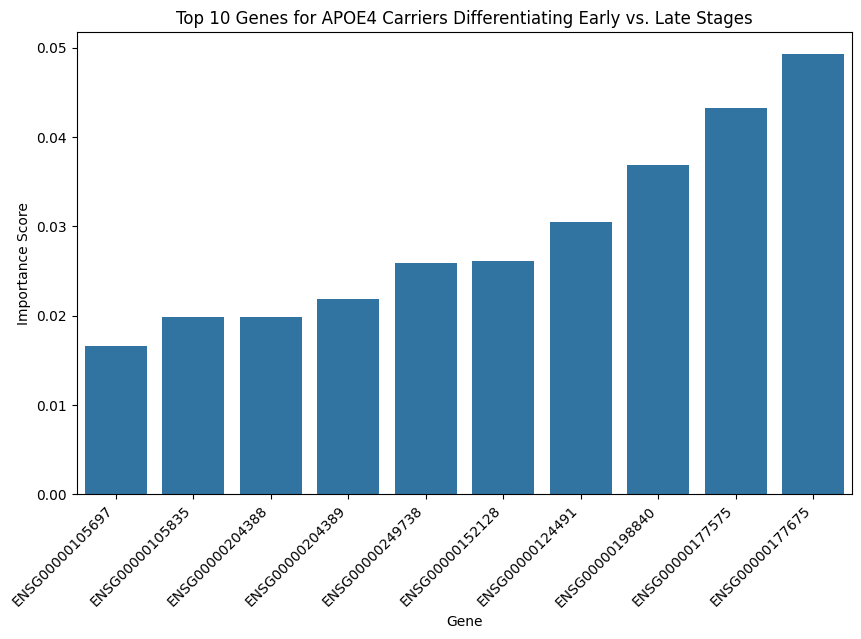


Classification Report for APOE4 Non-Carriers:
              precision    recall  f1-score   support

           0       0.95      0.88      0.91      6581
           1       0.89      0.95      0.92      6539

    accuracy                           0.92     13120
   macro avg       0.92      0.92      0.91     13120
weighted avg       0.92      0.92      0.91     13120

Top genes associated with stage progression for APOE4 Non-Carriers:
['ENSG00000115956' 'ENSG00000204389' 'ENSG00000118785' 'ENSG00000231535'
 'ENSG00000176728' 'ENSG00000120694' 'ENSG00000105697' 'ENSG00000198840'
 'ENSG00000059804' 'ENSG00000152128']


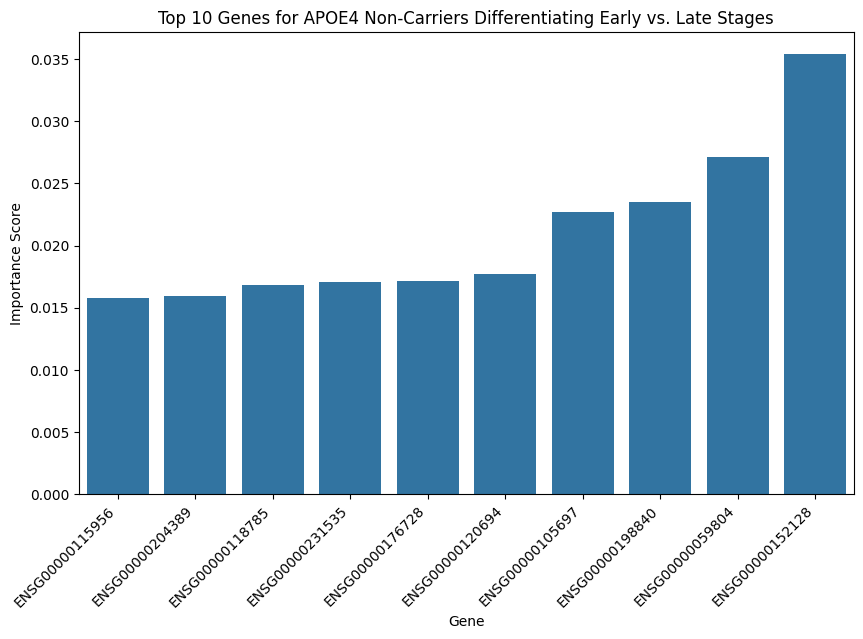

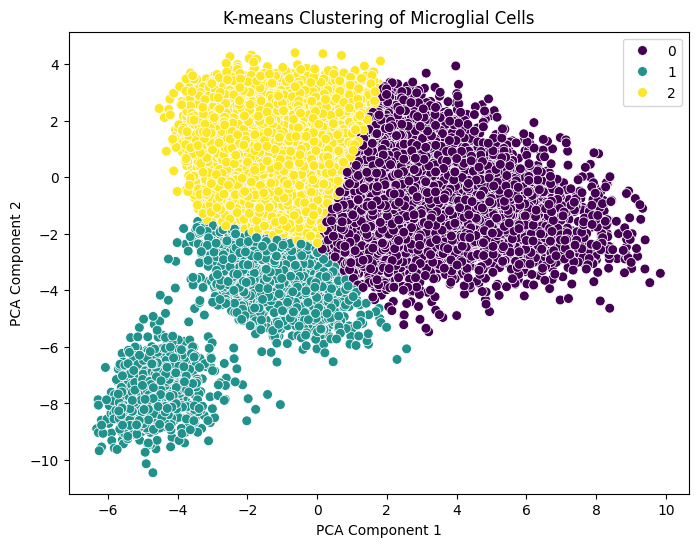

In [ ]:
# Step 1: Load and Filter the Dataset
adata = adata_mtg_filtered  # Assuming 'adata_mtg_filtered' is pre-loaded with the necessary data

# Step 2: Select highly variable genes (feature selection)
sc.pp.highly_variable_genes(adata, n_top_genes=300)
adata = adata[:, adata.var['highly_variable']]

# Step 3: Define early and late stage groups based on Braak stages (excluding 'Reference')
adata = adata[adata.obs['Braak stage'] != 'Reference']
adata.obs['Stage'] = adata.obs['Braak stage'].apply(lambda x: 0 if x in ['Braak 0', 'Braak II', 'Braak III'] else 1)  # 0 = Early, 1 = Late

# Step 4: Split data for APOE4 carriers and non-carriers
carriers = adata[adata.obs['APOE4 status'] == 'Y']
non_carriers = adata[adata.obs['APOE4 status'] == 'N']

# Step 5: Prepare data and labels for classification
def prepare_data(adata):
    X = adata.X.toarray()  # Assuming sparse matrix format, convert to dense if needed
    y = adata.obs['Stage'].values
    return X, y

X_carriers, y_carriers = prepare_data(carriers)
X_non_carriers, y_non_carriers = prepare_data(non_carriers)

# Step 6: Address Class Imbalance Using SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_carriers_resampled, y_carriers_resampled = smote.fit_resample(X_carriers, y_carriers)
X_non_carriers_resampled, y_non_carriers_resampled = smote.fit_resample(X_non_carriers, y_non_carriers)

# Step 7: Train-Test Split
X_train_carriers, X_test_carriers, y_train_carriers, y_test_carriers = train_test_split(X_carriers_resampled, y_carriers_resampled, test_size=0.3, random_state=42)
X_train_non_carriers, X_test_non_carriers, y_train_non_carriers, y_test_non_carriers = train_test_split(X_non_carriers_resampled, y_non_carriers_resampled, test_size=0.3, random_state=42)

# Step 8: Train Random Forest Classifier with Balanced Class Weights
def train_evaluate_rf(X_train, X_test, y_train, y_test, label):
    class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

    rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight=class_weights_dict)
    rf.fit(X_train, y_train)

    # Predictions and Evaluation
    y_pred = rf.predict(X_test)
    print(f"\nClassification Report for {label}:")
    print(classification_report(y_test, y_pred))

    # Feature importance
    feature_importances = rf.feature_importances_
    important_genes = np.array(adata.var_names)[np.argsort(feature_importances)[-10:]]  # Top 10 genes
    print(f"Top genes associated with stage progression for {label}:")
    print(important_genes)

    # Plot feature importance for top genes
    plt.figure(figsize=(10, 6))
    sns.barplot(x=important_genes, y=feature_importances[np.argsort(feature_importances)[-10:]])
    plt.xticks(rotation=45, ha='right')
    plt.xlabel("Gene")
    plt.ylabel("Importance Score")
    plt.title(f"Top 10 Genes for {label} Differentiating Early vs. Late Stages")
    plt.show()

# Step 9: Run model for both APOE4 carriers and non-carriers
train_evaluate_rf(X_train_carriers, X_test_carriers, y_train_carriers, y_test_carriers, "APOE4 Carriers")
train_evaluate_rf(X_train_non_carriers, X_test_non_carriers, y_train_non_carriers, y_test_non_carriers, "APOE4 Non-Carriers")

# Step 10: Clustering Analysis to Identify Subpopulations
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
X_pca = pca.fit_transform(adata.X.toarray())

# Apply K-means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(X_pca)

# Plot the clustering results
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=kmeans_labels, palette='viridis', s=50)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('K-means Clustering of Microglial Cells')
plt.show()




#### Data Preparation and Feature Selection
- **Dataset**: The filtered dataset included microglial cells across Braak stages 0, II, III (early) and Braak IV, V, VI (late), excluding reference samples.
- **Highly Variable Genes**: Selected top 300 highly variable genes for feature selection.
- **Groups**: Data split into APOE4 carriers and non-carriers, further classified into early vs. late stage AD.
- **Class Balancing**: Applied SMOTE to address class imbalance between early and late stages.

#### Model Training and Evaluation
- **Classifier**: Random Forest classifier trained with balanced class weights.
- **Accuracy**: High accuracy observed for both carriers (98%) and non-carriers (92%).
- **Top Genes Identified**:
  - **APOE4 Carriers**: Top genes include HAMP, TMEM163, and F13A1, among others.
  - **APOE4 Non-Carriers**: Top genes include ENSG00000115956 (PLEK), ENSG00000152128 (TMEM163), and ENSG00000105697 (HAMP), among others.

#### Clustering Analysis
- **PCA and K-means Clustering**: Applied PCA for dimensionality reduction and K-means clustering to identify subpopulations of microglial cells.
- **Results**: Three clusters were identified, indicating distinct cellular subpopulations with potentially different roles in AD progression.

#### Interpretation of Results
- **APOE4 Carriers**: The Random Forest model effectively distinguished between early and late AD stages, highlighting key genes like HAMP, TMEM163, and F13A1 involved in inflammatory and neurotoxic processes.
- **APOE4 Non-Carriers**: The model also showed high accuracy for non-carriers, identifying genes such as PLEK, TMEM163, and HAMP linked to disease progression, suggesting that non-APOE4 pathways influence AD.
- **Clustering**: K-means clustering identified three distinct microglial subpopulations, indicating varying microglial phenotypes that may transition from neuroprotective to neurotoxic roles during AD progression.

#### Conclusion
The analysis highlights specific genes associated with AD stage progression, with a clear distinction between APOE4 carriers and non-carriers. Clustering analysis provides further insights into the heterogeneity of microglial activation, underlining the complexity of AD pathology.


## Model APOE4

In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Clean the 'APOE4 status' column by removing rows where 'Reference' is present
adata_mtg = adata_mtg[adata_mtg.obs['APOE4 status'] != 'Reference']

# Verify the cleaned data
print(adata_mtg.obs['APOE4 status'].unique())

# Define target variable for APOE4 classification
target_apoe4 = adata_mtg.obs['APOE4 status']  # Binary classification: Y/N

# Define features (drop the target columns from the obs DataFrame)
features = adata_mtg.obs.drop(columns=["APOE4 status", "stage"])

# Split data for APOE4 classification
X_apoe4_train, X_apoe4_test, y_apoe4_train, y_apoe4_test = train_test_split(
    features, target_apoe4, test_size=0.2, random_state=42, stratify=target_apoe4
)

# Define preprocessing pipeline
categorical_features = features.select_dtypes(include=["object"]).columns
numerical_features = features.select_dtypes(include=["int64", "float64"]).columns

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ]
)

# Random Forest Classifier
rf_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", RandomForestClassifier(random_state=42)),
    ]
)

# Evaluate model function
def evaluate_model(pipeline, X_train, X_test, y_train, y_test, target_name):
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:, 1] if hasattr(pipeline, "predict_proba") else None
    print(f"Results for {target_name}:")
    print(classification_report(y_test, y_pred))
    if y_proba is not None:
        print(f"AUC-ROC: {roc_auc_score(y_test, y_proba):.4f}")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}\n")

# Evaluate APOE4 model
print("APOE4 Status Classification")
evaluate_model(rf_pipeline, X_apoe4_train, X_apoe4_test, y_apoe4_train, y_apoe4_test, "APOE4 - Random Forest")


['N', 'Y']
Categories (2, object): ['N', 'Y']
APOE4 Status Classification
Results for APOE4 - Random Forest:
              precision    recall  f1-score   support

           N       0.93      0.99      0.96      5480
           Y       0.98      0.81      0.89      2301

    accuracy                           0.94      7781
   macro avg       0.95      0.90      0.92      7781
weighted avg       0.94      0.94      0.94      7781

AUC-ROC: 0.9922
Accuracy: 0.9391



### Model Results (APOE4 - Random Forest):

Overall Metrics:
- Accuracy: 0.94 (indicating the model is correctly classifying 94% of the cases)
- AUC-ROC: 0.9917 (which suggests that the model is very good at distinguishing between APOE4 carriers and non-carriers)
- Macro average F1-Score: 0.92 (which takes into account both classes)
- Weighted average F1-Score: 0.93 (weighted by the number of samples in each class)

Key Takeaways:
1. The model performs very well overall, with a high recall for the 'Non-carrier' class (0.99), indicating that the model is effective at identifying APOE4 non-carriers.

2. For the 'Carrier' class, while the precision (0.98) is high, the recall (0.80) is a bit lower. This means that the model misses some APOE4 carriers (false negatives).

3. The AUC-ROC score (0.9917) confirms that the model is excellent at distinguishing between the two classes.

Next Steps:
You might consider balancing the recall for both classes, especially the 'Y' class (APOE4 carrier). Techniques like oversampling, undersampling, or adjusting class weights in the model could help improve recall for the 'Y' class.


## Model APOE4 Optimization

In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from scipy.stats import randint, uniform
import numpy as np

# Clean the 'APOE4 status' column by removing rows where 'Reference' is present
adata_mtg = adata_mtg[adata_mtg.obs['APOE4 status'] != 'Reference']

# Define target variable for APOE4 classification
target_apoe4 = adata_mtg.obs['APOE4 status']  # Binary classification: 'N'/'Y'

# Map target labels ('N', 'Y') to numerical values (0, 1)
label_mapping = {'N': 0, 'Y': 1}
target_apoe4_numeric = target_apoe4.map(label_mapping)

# Debug Step: Check for missing values in the target variable
print("Missing values in target_apoe4_numeric:", target_apoe4_numeric.isnull().sum())

# Drop rows with missing target values
valid_indices = target_apoe4_numeric.dropna().index
features = adata_mtg.obs.loc[valid_indices].drop(columns=["APOE4 status", "stage"])
target_apoe4_numeric = target_apoe4_numeric.loc[valid_indices]

# Debug Step: Check the number of valid samples
print("Number of valid samples after filtering:", len(features))

# Ensure no NaN values remain in the feature dataset
features = features.dropna()

# Debug Step: Check for alignment between features and target
print("Feature dataset size:", features.shape)
print("Target dataset size:", target_apoe4_numeric.shape)

# Split data for APOE4 classification
X_apoe4_train, X_apoe4_test, y_apoe4_train, y_apoe4_test = train_test_split(
    features, target_apoe4_numeric, test_size=0.2, random_state=42, stratify=target_apoe4_numeric
)

# Define preprocessing pipeline
categorical_features = features.select_dtypes(include=["object"]).columns
numerical_features = features.select_dtypes(include=["int64", "float64"]).columns

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_features),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=True), categorical_features),
    ]
)

# Apply preprocessing to training data for SMOTE
X_apoe4_train_preprocessed = preprocessor.fit_transform(X_apoe4_train)
X_apoe4_test_preprocessed = preprocessor.transform(X_apoe4_test)

# Using SMOTE for oversampling the training data
smote = SMOTE(random_state=42)
X_apoe4_train_resampled, y_apoe4_train_resampled = smote.fit_resample(X_apoe4_train_preprocessed, y_apoe4_train)

# Random Forest Classifier with Randomized Search
rf = RandomForestClassifier(random_state=42, n_jobs=-1)
param_dist_rf = {
    'n_estimators': randint(50, 150),
    'max_depth': [None, 10],
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5),
    'class_weight': ['balanced']
}

random_search_rf = RandomizedSearchCV(rf, param_distributions=param_dist_rf, n_iter=10, cv=3, scoring='accuracy', n_jobs=-1, random_state=42)
random_search_rf.fit(X_apoe4_train_resampled, y_apoe4_train_resampled)

# Best Random Forest parameters
best_rf = random_search_rf.best_estimator_
print("Best parameters for Random Forest:", random_search_rf.best_params_)
print("Best cross-validation score:", random_search_rf.best_score_)

# Evaluate model function
def evaluate_model(model, X_train, X_test, y_train, y_test, target_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    print(f"Results for {target_name}:")
    print(classification_report(y_test, y_pred))
    if y_proba is not None:
        print(f"AUC-ROC: {roc_auc_score(y_test, y_proba):.4f}")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}\n")

# Evaluate Random Forest
print("APOE4 Status Classification with Random Forest")
evaluate_model(best_rf, X_apoe4_train_resampled, X_apoe4_test_preprocessed, y_apoe4_train_resampled, y_apoe4_test, "APOE4 - Random Forest")

# XGBoost Classifier
xgb = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42, n_jobs=-1)
print("APOE4 Status Classification with XGBoost")
evaluate_model(xgb, X_apoe4_train_resampled, X_apoe4_test_preprocessed, y_apoe4_train_resampled, y_apoe4_test, "APOE4 - XGBoost")

# Logistic Regression Classifier
lr = LogisticRegression(max_iter=500, random_state=42, n_jobs=-1)
print("APOE4 Status Classification with Logistic Regression")
evaluate_model(lr, X_apoe4_train_resampled, X_apoe4_test_preprocessed, y_apoe4_train_resampled, y_apoe4_test, "APOE4 - Logistic Regression")


Missing values in target_apoe4_numeric: 0
Number of valid samples after filtering: 38905
Feature dataset size: (38905, 41)
Target dataset size: (38905,)
Best parameters for Random Forest: {'class_weight': 'balanced', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 107}
Best cross-validation score: 0.9662408940875772
APOE4 Status Classification with Random Forest
Results for APOE4 - Random Forest:
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      5480
           1       0.94      0.86      0.90      2301

    accuracy                           0.94      7781
   macro avg       0.94      0.92      0.93      7781
weighted avg       0.94      0.94      0.94      7781

AUC-ROC: 0.9860
Accuracy: 0.9406

APOE4 Status Classification with XGBoost


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:21:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Results for APOE4 - XGBoost:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5480
           1       0.99      1.00      1.00      2301

    accuracy                           1.00      7781
   macro avg       1.00      1.00      1.00      7781
weighted avg       1.00      1.00      1.00      7781

AUC-ROC: 1.0000
Accuracy: 0.9976

APOE4 Status Classification with Logistic Regression
Results for APOE4 - Logistic Regression:
              precision    recall  f1-score   support

           0       0.88      0.68      0.77      5480
           1       0.51      0.78      0.62      2301

    accuracy                           0.71      7781
   macro avg       0.69      0.73      0.69      7781
weighted avg       0.77      0.71      0.72      7781

AUC-ROC: 0.8128
Accuracy: 0.7110



In [16]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.feature_selection import SelectFromModel
import shap

# Split data (using previously preprocessed data)
X_train, X_val, y_train, y_val = train_test_split(X_apoe4_train_resampled, y_apoe4_train_resampled, test_size=0.2, random_state=42)

# Define XGBoost model with regularization parameters for Grid Search
xgb_model = xgb.XGBClassifier(
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss',
    n_jobs=-1
)

# Set up parameter grid for tuning, focusing on regularization to reduce overfitting
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'reg_alpha': [0, 0.1, 0.5],  # L1 regularization
    'reg_lambda': [1, 1.5, 2]     # L2 regularization
}

# GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Fit the model to find the best parameters
grid_search.fit(X_train, y_train)

# Display the best parameters found
best_xgb = grid_search.best_estimator_
print("Best parameters for XGBoost:", grid_search.best_params_)

# Evaluate the optimized model
def evaluate_model(model, X_train, X_test, y_train, y_test, target_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    print(f"Results for {target_name}:")
    print(classification_report(y_test, y_pred))
    if y_proba is not None:
        print(f"AUC-ROC: {roc_auc_score(y_test, y_proba):.4f}")

# Evaluate optimized XGBoost
evaluate_model(best_xgb, X_train, X_val, y_train, y_val, "APOE4 - Optimized XGBoost")


Fitting 3 folds for each of 1458 candidates, totalling 4374 fits


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:02:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters for XGBoost: {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 150, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:02:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Results for APOE4 - Optimized XGBoost:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      4405
           1       1.00      0.98      0.99      4363

    accuracy                           0.99      8768
   macro avg       0.99      0.99      0.99      8768
weighted avg       0.99      0.99      0.99      8768

AUC-ROC: 0.9991


## APOE4 Specific Genes

**NAMPT:** As a key enzyme in NAD+ biosynthesis, NAMPT plays a vital role in energy metabolism, ATP production, and mitochondrial health. Our research highlights its potential as a therapeutic target for APOE4 carriers, addressing energy deficits in AD.

**NEU1:** NEU1 modulates immune responses, which is critical in managing neuroinflammation. We find NEU1 particularly relevant for APOE4 carriers, offering a therapeutic target for controlling AD-related immune responses.

**CD163 and CD163L1:** Linked to inflammation and small-vessel injury in early AD, these genes are upregulated by amyloid beta plaques. We identify their potential for targeted therapies to maintain vascular health, particularly in APOE4 carriers who are more prone to vascular complications in AD.


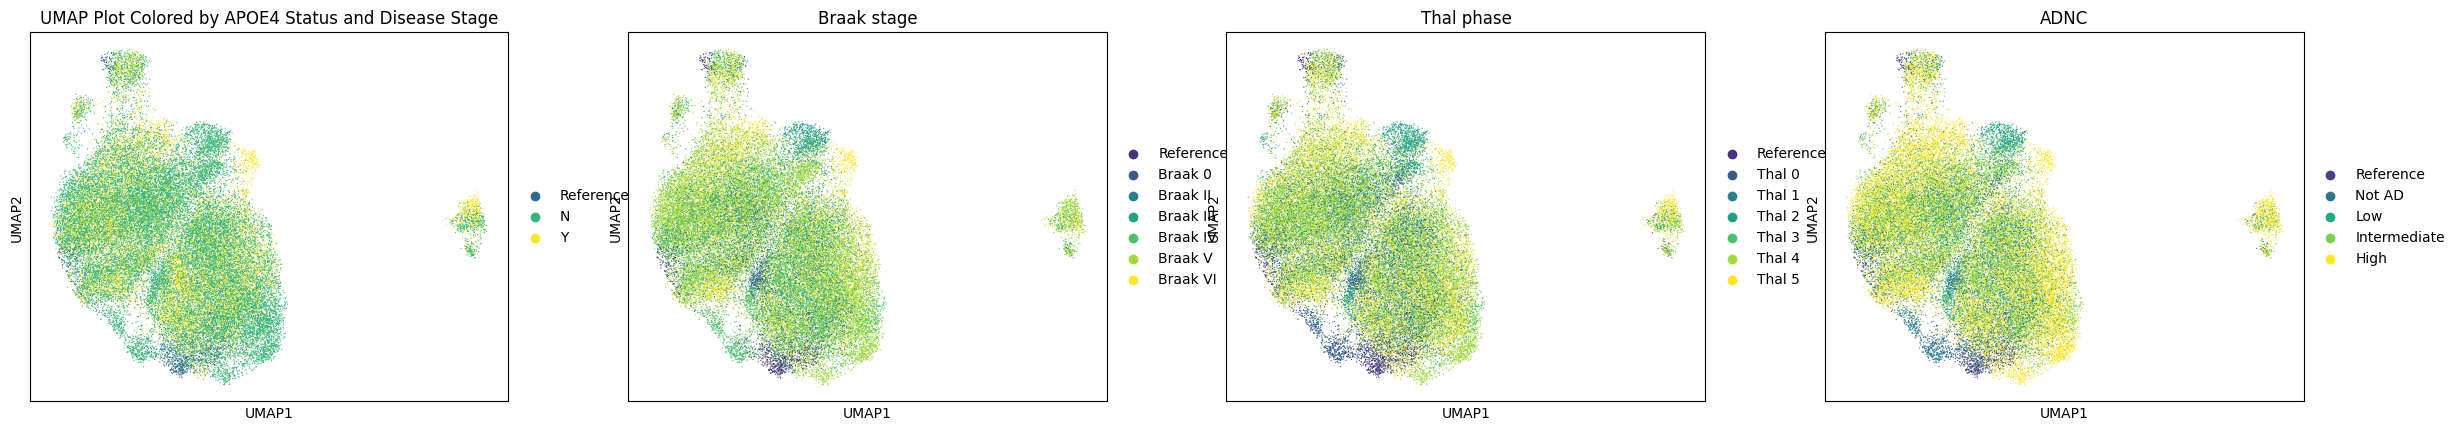

In [ ]:
# Compute PCA and UMAP
sc.tl.pca(adata_mtg_filtered)
sc.pp.neighbors(adata_mtg_filtered)
sc.tl.umap(adata_mtg_filtered)

# Plot UMAP
sc.pl.umap(adata_mtg_filtered, color=['APOE4 status', 'Braak stage', 'Thal phase', 'ADNC'],
           title="UMAP Plot Colored by APOE4 Status and Disease Stage")


**APOE4 Status (First Plot):**

The UMAP plot illustrates the distribution of microglial cells based on APOE4 status (Y for carriers, N for non-carriers, and a reference group).
Clusters: If there are distinct clusters for carriers and non-carriers, this suggests that the microglial cell populations differ significantly in their expression profiles based on APOE4 status.
Distribution: The presence of overlapping areas indicates that there may be shared characteristics among carriers and non-carriers, or potential transitional states in microglial activation.

**Braak Stage (Second Plot):**

This plot shows how microglial cells cluster according to the Braak stage, a measure of the progression of neurofibrillary tangles in AD.
Progression Indicator: Distinct groups for different Braak stages imply that microglial activation varies significantly as the disease progresses, with later stages potentially showing different activation patterns.
Color Gradation: If there is a smooth gradient from early to late Braak stages, it suggests a continuum of activation states in microglia in response to disease progression.

**Thal Phase (Third Plot):**

The Thal phase reflects the extent of amyloid pathology in the brain. Similar to the Braak stage, this plot indicates how microglial cells cluster based on this measure.
Clustering Patterns: The arrangement of microglial cells in relation to Thal phases can provide insight into how amyloid pathology influences microglial behavior.
Overlapping Clusters: The presence of overlapping clusters across Thal phases may indicate that some microglial cells retain similar characteristics despite differing degrees of amyloid burden.

**ADNC (Fourth Plot):**

ADNC categorizes the microglial cells based on their cognitive status, ranging from "Not AD" to various stages of Alzheimer's severity (Low, Intermediate, High).
Cognitive Decline Representation: A clear separation of clusters corresponding to ADNC status suggests that microglial activation is influenced by cognitive decline severity.
Correlation with Other Stages: Comparing this plot with the Braak stage and Thal phase plots may reveal how cognitive impairment relates to microglial activation patterns across different stages of pathology.

**Insights:**
- Microglial Activation Shifts: The results indicate that microglial activation may shift based on both genetic (APOE4 status) and pathological (Braak and Thal stages, ADNC status) factors.

- Potential Targets for Therapy: Understanding how microglial activation varies across these parameters could help identify potential therapeutic targets in Alzheimer's disease treatment, especially for APOE4 carriers who may be at greater risk for neurodegeneration.
